In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Load data from Excel file
file_path = r"E:\test\sleep\Final_results.xlsx"

human1 = pd.read_excel(file_path, sheet_name="human1")
human2 = pd.read_excel(file_path, sheet_name="human2")
info = pd.read_excel(file_path, sheet_name="Info")

print("Data loaded successfully!")
print(f"Human1 shape: {human1.shape}")
print(f"Human2 shape: {human2.shape}")
print(f"Info shape: {info.shape}")
print(f"\nColumns in human1: {list(human1.columns)}")

Data loaded successfully!
Human1 shape: (129, 14)
Human2 shape: (129, 12)
Info shape: (129, 14)

Columns in human1: ['Unnamed: 0', 'Age', 'Gender', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']


In [2]:
# Define model column mappings for human1 and human2
model_columns = {
    "Grok": ("Grok", "Grok"),
    "Claude": ("Claude", "Claude"),
    "Deepseek": ("Deepseek", "Deepseek"),
    "GPT": ("GPT", "GPT"),
    "Gemini": ("Gemini", "Gemini"),
}

model_names = list(model_columns.keys())
print(f"Models to analyze: {model_names}")

Models to analyze: ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']


In [3]:
# Calculate Cohen's Kappa (quadratic weighted) for each model
kappa_results = {}

print("=" * 60)
print("COHEN'S KAPPA (Inter-rater Reliability) - Per Model")
print("=" * 60)

for model, (col_h1, col_h2) in model_columns.items():
    scores_h1 = human1[col_h1]
    scores_h2 = human2[col_h2]
    
    # Drop rows with missing values
    valid = scores_h1.notna() & scores_h2.notna()
    n_valid = valid.sum()
    
    kappa = cohen_kappa_score(
        scores_h1[valid],
        scores_h2[valid],
        weights="quadratic"
    )
    
    kappa_results[model] = kappa
    print(f"{model:12s}: κ = {kappa:.4f} (n = {n_valid})")

print("=" * 60)

COHEN'S KAPPA (Inter-rater Reliability) - Per Model
Grok        : κ = 0.6490 (n = 129)
Claude      : κ = 0.6825 (n = 129)
Deepseek    : κ = 0.6126 (n = 129)
GPT         : κ = 0.5685 (n = 129)
Gemini      : κ = 0.6421 (n = 129)


In [4]:
# Calculate overall Cohen's Kappa across all models
all_h1 = []
all_h2 = []

for model, (col_h1, col_h2) in model_columns.items():
    valid = human1[col_h1].notna() & human2[col_h2].notna()
    all_h1.extend(human1.loc[valid, col_h1])
    all_h2.extend(human2.loc[valid, col_h2])

overall_kappa = cohen_kappa_score(
    all_h1,
    all_h2,
    weights="quadratic"
)

print("\n" + "=" * 60)
print("OVERALL COHEN'S KAPPA (All Models Combined)")
print("=" * 60)
print(f"Overall κ = {overall_kappa:.4f} (n = {len(all_h1)} total ratings)")
print("=" * 60)


OVERALL COHEN'S KAPPA (All Models Combined)
Overall κ = 0.6349 (n = 645 total ratings)


In [5]:
# Create averaged scores (mean of human1 and human2)
human_avg = info.copy()  # Start with Info sheet to keep metadata

# Calculate average scores for each model
for model, (col_h1, col_h2) in model_columns.items():
    human_avg[model] = (human1[col_h1] + human2[col_h2]) / 2

print("\n" + "=" * 60)
print("AVERAGED SCORES COMPUTED")
print("=" * 60)
print(f"human_avg shape: {human_avg.shape}")
print(f"Columns in human_avg: {list(human_avg.columns)}")

# Save back to the same Excel file with human_avg sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    human_avg.to_excel(writer, sheet_name='human_avg', index=False)

print("\n✓ 'human_avg' sheet successfully saved to Excel file!")
print("=" * 60)


AVERAGED SCORES COMPUTED
human_avg shape: (129, 19)
Columns in human_avg: ['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

✓ 'human_avg' sheet successfully saved to Excel file!


In [6]:
# Calculate basic statistics for each model using averaged scores
print("\n" + "=" * 80)
print("BASIC STATISTICS - AVERAGED SCORES (human_avg)")
print("=" * 80)

stats_summary = []

for model in model_names:
    scores = human_avg[model].dropna()
    
    stats_dict = {
        'Model': model,
        'N': len(scores),
        'Mean': scores.mean(),
        'Median': scores.median(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max(),
        'Q1': scores.quantile(0.25),
        'Q3': scores.quantile(0.75)
    }
    stats_summary.append(stats_dict)

stats_df = pd.DataFrame(stats_summary)
print(stats_df.to_string(index=False))
print("=" * 80)


BASIC STATISTICS - AVERAGED SCORES (human_avg)
   Model   N     Mean  Median      Std  Min  Max  Q1  Q3
    Grok 129 3.945736     5.0 1.612016  0.0  5.0 3.5 5.0
  Claude 129 4.031008     5.0 1.633095  0.0  5.0 4.0 5.0
Deepseek 129 4.143411     5.0 1.546409  0.0  5.0 4.0 5.0
     GPT 129 4.217054     5.0 1.419514  0.0  5.0 4.0 5.0
  Gemini 129 3.984496     5.0 1.621316  0.0  5.0 4.0 5.0


In [7]:
# Calculate Top-K accuracy for each model
print("\n" + "=" * 80)
print("TOP-K ACCURACY ANALYSIS")
print("=" * 80)

topk_results = []

for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    # Top-1: Score = 5
    top1 = (scores == 5).sum()
    top1_pct = (top1 / n_total) * 100
    
    # Top-3: Score >= 3
    top3 = (scores >= 3).sum()
    top3_pct = (top3 / n_total) * 100
    
    # Top-5: Score >= 1
    top5 = (scores >= 1).sum()
    top5_pct = (top5 / n_total) * 100
    
    topk_results.append({
        'Model': model,
        'Top-1 (Score=5)': top1,
        'Top-1 %': top1_pct,
        'Top-3 (Score>=3)': top3,
        'Top-3 %': top3_pct,
        'Top-5 (Score>=1)': top5,
        'Top-5 %': top5_pct
    })

topk_df = pd.DataFrame(topk_results)
print(topk_df.to_string(index=False))
print("=" * 80)


TOP-K ACCURACY ANALYSIS
   Model  Top-1 (Score=5)   Top-1 %  Top-3 (Score>=3)   Top-3 %  Top-5 (Score>=1)   Top-5 %
    Grok               73 56.589147               102 79.069767               118 91.472868
  Claude               79 61.240310               101 78.294574               116 89.922481
Deepseek               79 61.240310               107 82.945736               116 89.922481
     GPT               79 61.240310               109 84.496124               120 93.023256
  Gemini               73 56.589147               102 79.069767               116 89.922481


In [8]:
# Calculate failure rates (Score = 0) for each model
print("\n" + "=" * 80)
print("FAILURE RATE ANALYSIS (Score = 0)")
print("=" * 80)

failure_results = []

for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    # Count failures (Score = 0)
    failures = (scores == 0).sum()
    failure_pct = (failures / n_total) * 100
    
    failure_results.append({
        'Model': model,
        'Failures': failures,
        'Total': n_total,
        'Failure %': failure_pct
    })

failure_df = pd.DataFrame(failure_results)
print(failure_df.to_string(index=False))
print("=" * 80)


FAILURE RATE ANALYSIS (Score = 0)
   Model  Failures  Total  Failure %
    Grok        11    129   8.527132
  Claude        12    129   9.302326
Deepseek        12    129   9.302326
     GPT         8    129   6.201550
  Gemini        12    129   9.302326


In [9]:
# Pairwise statistical comparison between models
from itertools import combinations

print("\n" + "=" * 80)
print("PAIRWISE STATISTICAL COMPARISON (Wilcoxon Signed-Rank Test)")
print("=" * 80)
print("H0: No difference between models | H1: Significant difference exists")
print("-" * 80)

comparison_results = []

for model1, model2 in combinations(model_names, 2):
    scores1 = human_avg[model1].dropna()
    scores2 = human_avg[model2].dropna()
    
    # Ensure same length for paired test
    valid_idx = human_avg[model1].notna() & human_avg[model2].notna()
    scores1 = human_avg.loc[valid_idx, model1]
    scores2 = human_avg.loc[valid_idx, model2]
    
    # Wilcoxon signed-rank test
    stat, p_value = stats.wilcoxon(scores1, scores2)
    
    mean_diff = scores1.mean() - scores2.mean()
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    comparison_results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Mean Diff': mean_diff,
        'p-value': p_value,
        'Sig': significance
    })
    
    print(f"{model1:12s} vs {model2:12s}: Δ={mean_diff:+.3f}, p={p_value:.4f} {significance}")

print("-" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("=" * 80)

comparison_df = pd.DataFrame(comparison_results)


PAIRWISE STATISTICAL COMPARISON (Wilcoxon Signed-Rank Test)
H0: No difference between models | H1: Significant difference exists
--------------------------------------------------------------------------------
Grok         vs Claude      : Δ=-0.085, p=0.3955 ns
Grok         vs Deepseek    : Δ=-0.198, p=0.0233 *
Grok         vs GPT         : Δ=-0.271, p=0.0024 **
Grok         vs Gemini      : Δ=-0.039, p=0.6788 ns
Claude       vs Deepseek    : Δ=-0.112, p=0.3174 ns
Claude       vs GPT         : Δ=-0.186, p=0.0203 *
Claude       vs Gemini      : Δ=+0.047, p=0.8994 ns
Deepseek     vs GPT         : Δ=-0.074, p=0.3223 ns
Deepseek     vs Gemini      : Δ=+0.159, p=0.1688 ns
GPT          vs Gemini      : Δ=+0.233, p=0.0834 ns
--------------------------------------------------------------------------------
Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


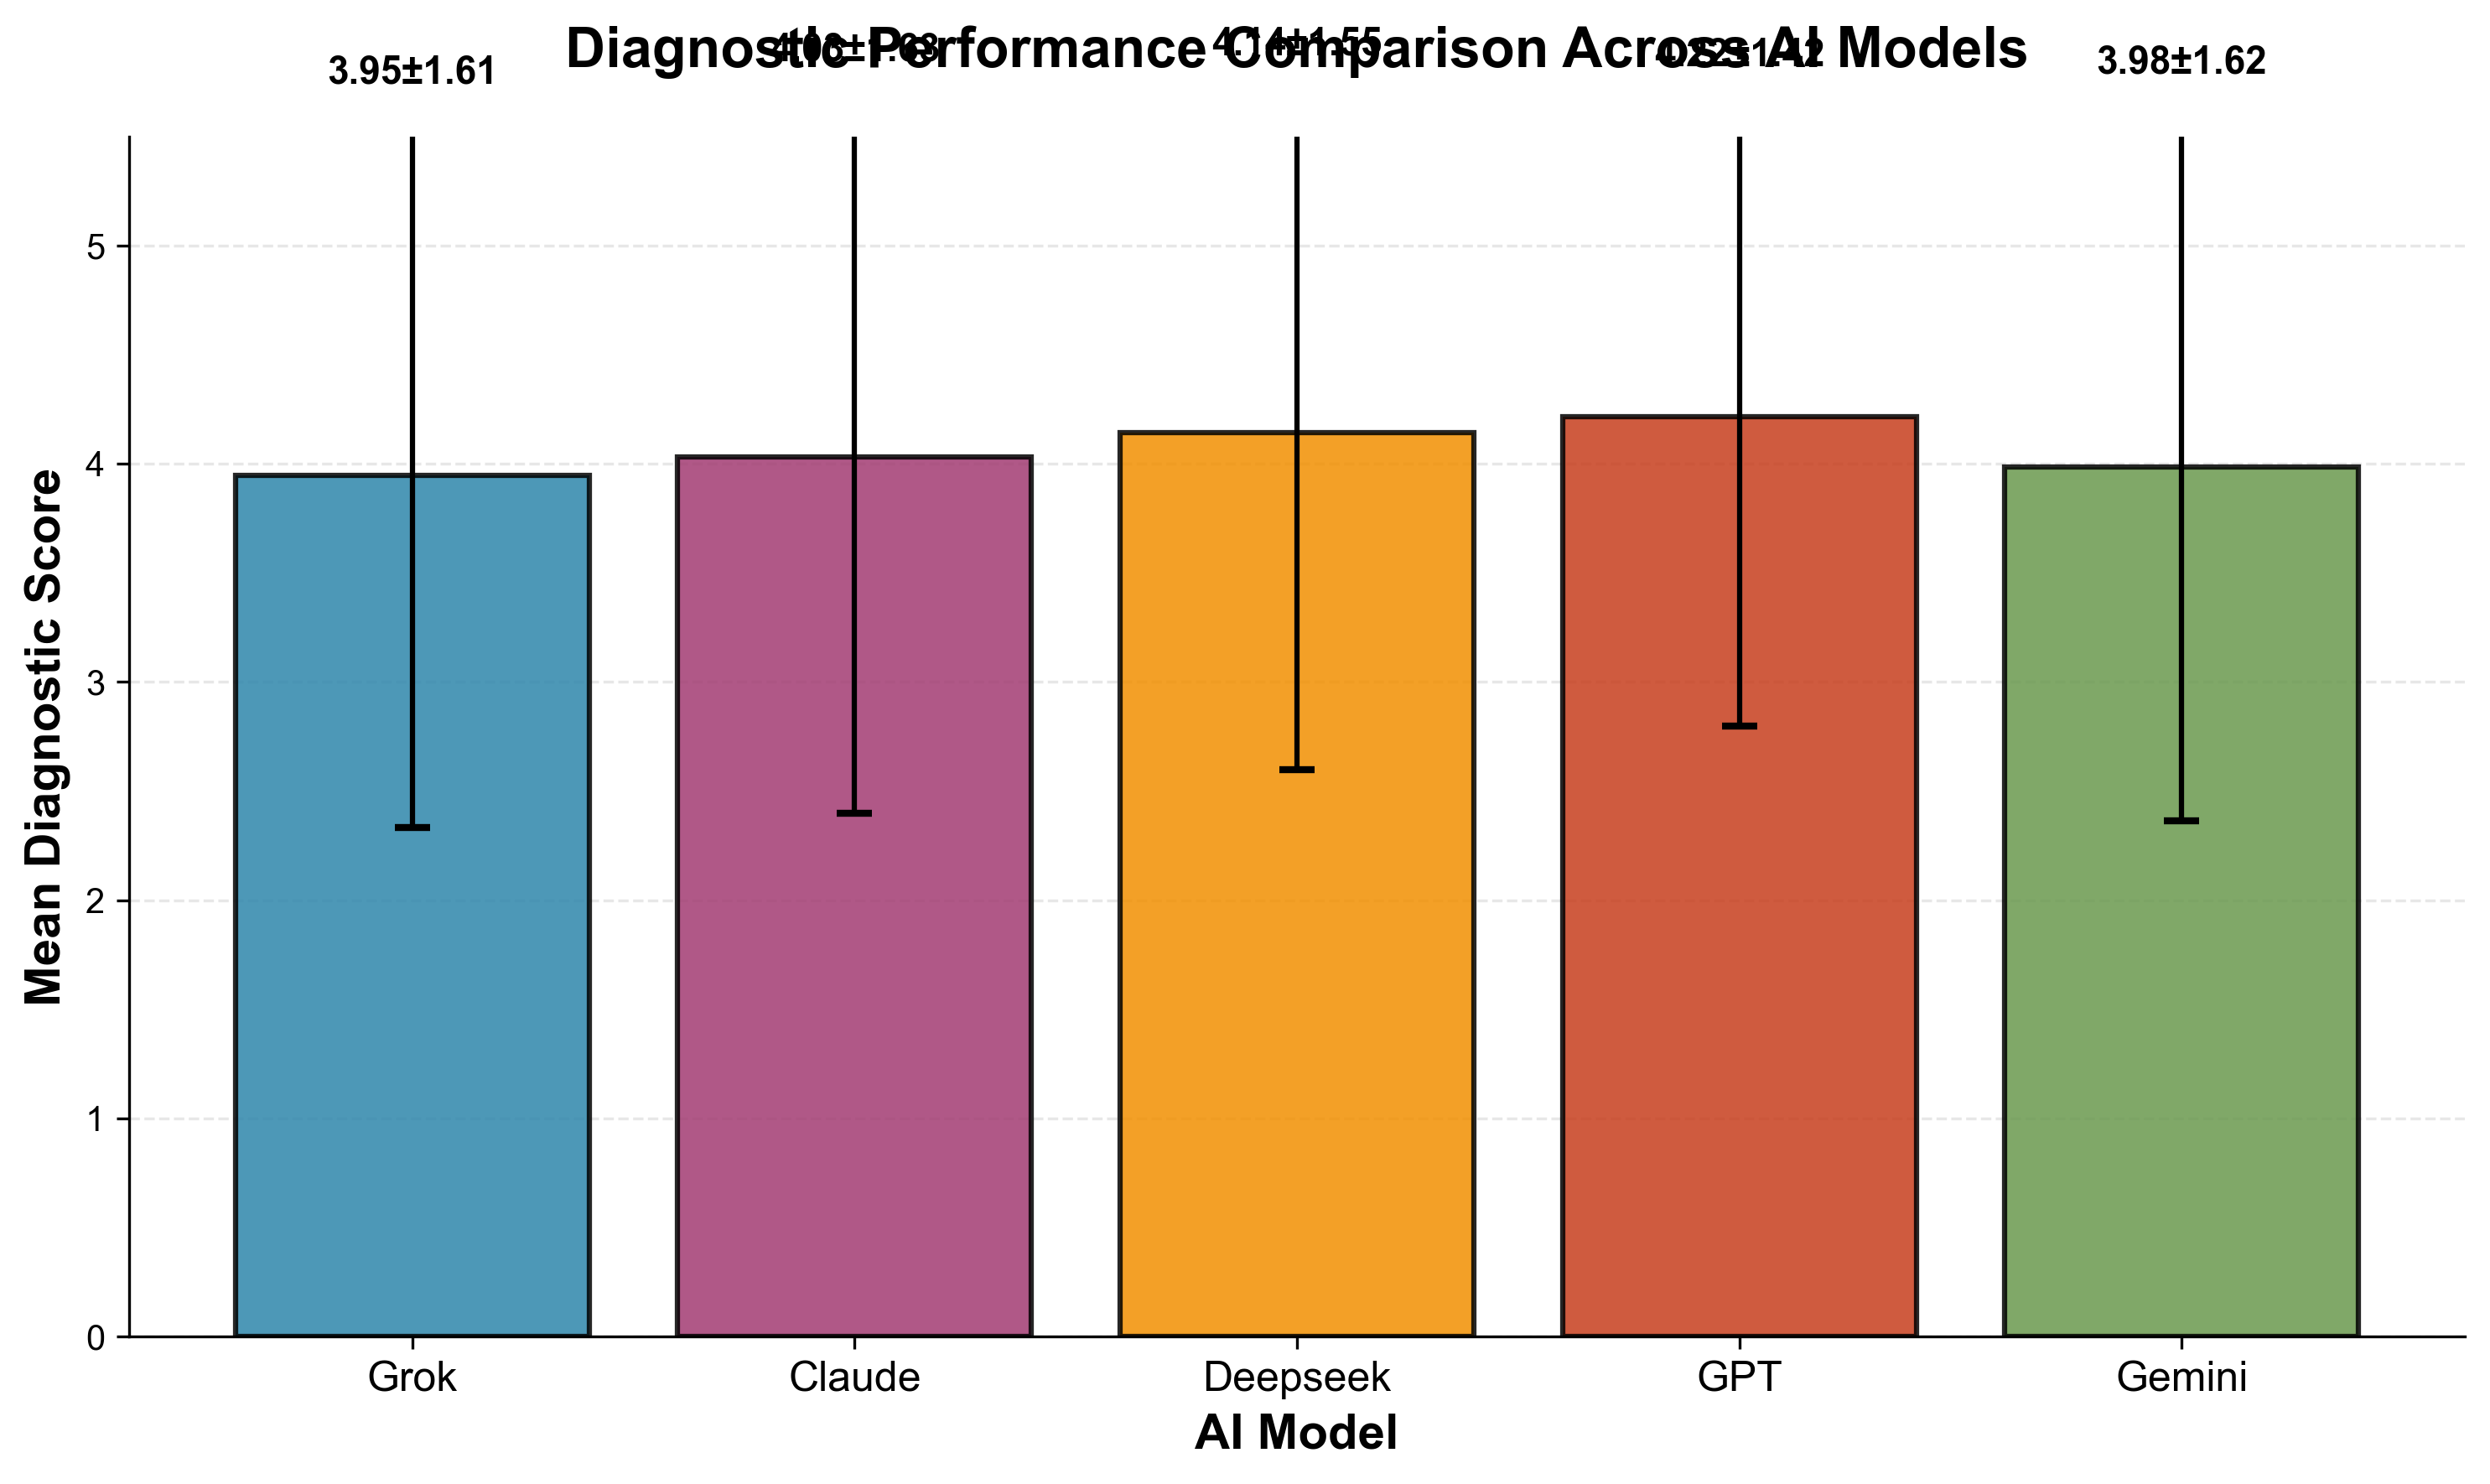

✓ Figure 1 saved: fig1_mean_scores_comparison.png/.pdf


In [10]:
# Publication-ready bar plot for mean scores
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
mean_scores = [human_avg[model].mean() for model in model_names]
std_scores = [human_avg[model].std() for model in model_names]

# Define colors (professional palette)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# Create bars
x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, mean_scores, color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

# Add error bars (standard deviation)
ax.errorbar(x_pos, mean_scores, yerr=std_scores, fmt='none', 
            ecolor='black', capsize=5, capthick=2, linewidth=1.5)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_scores, std_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.15,
            f'{mean:.2f}±{std:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Styling
ax.set_ylabel('Mean Diagnostic Score', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Model', fontsize=14, fontweight='bold')
ax.set_title('Diagnostic Performance Comparison Across AI Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.set_ylim(0, 5.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('fig1_mean_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('fig1_mean_scores_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: fig1_mean_scores_comparison.png/.pdf")

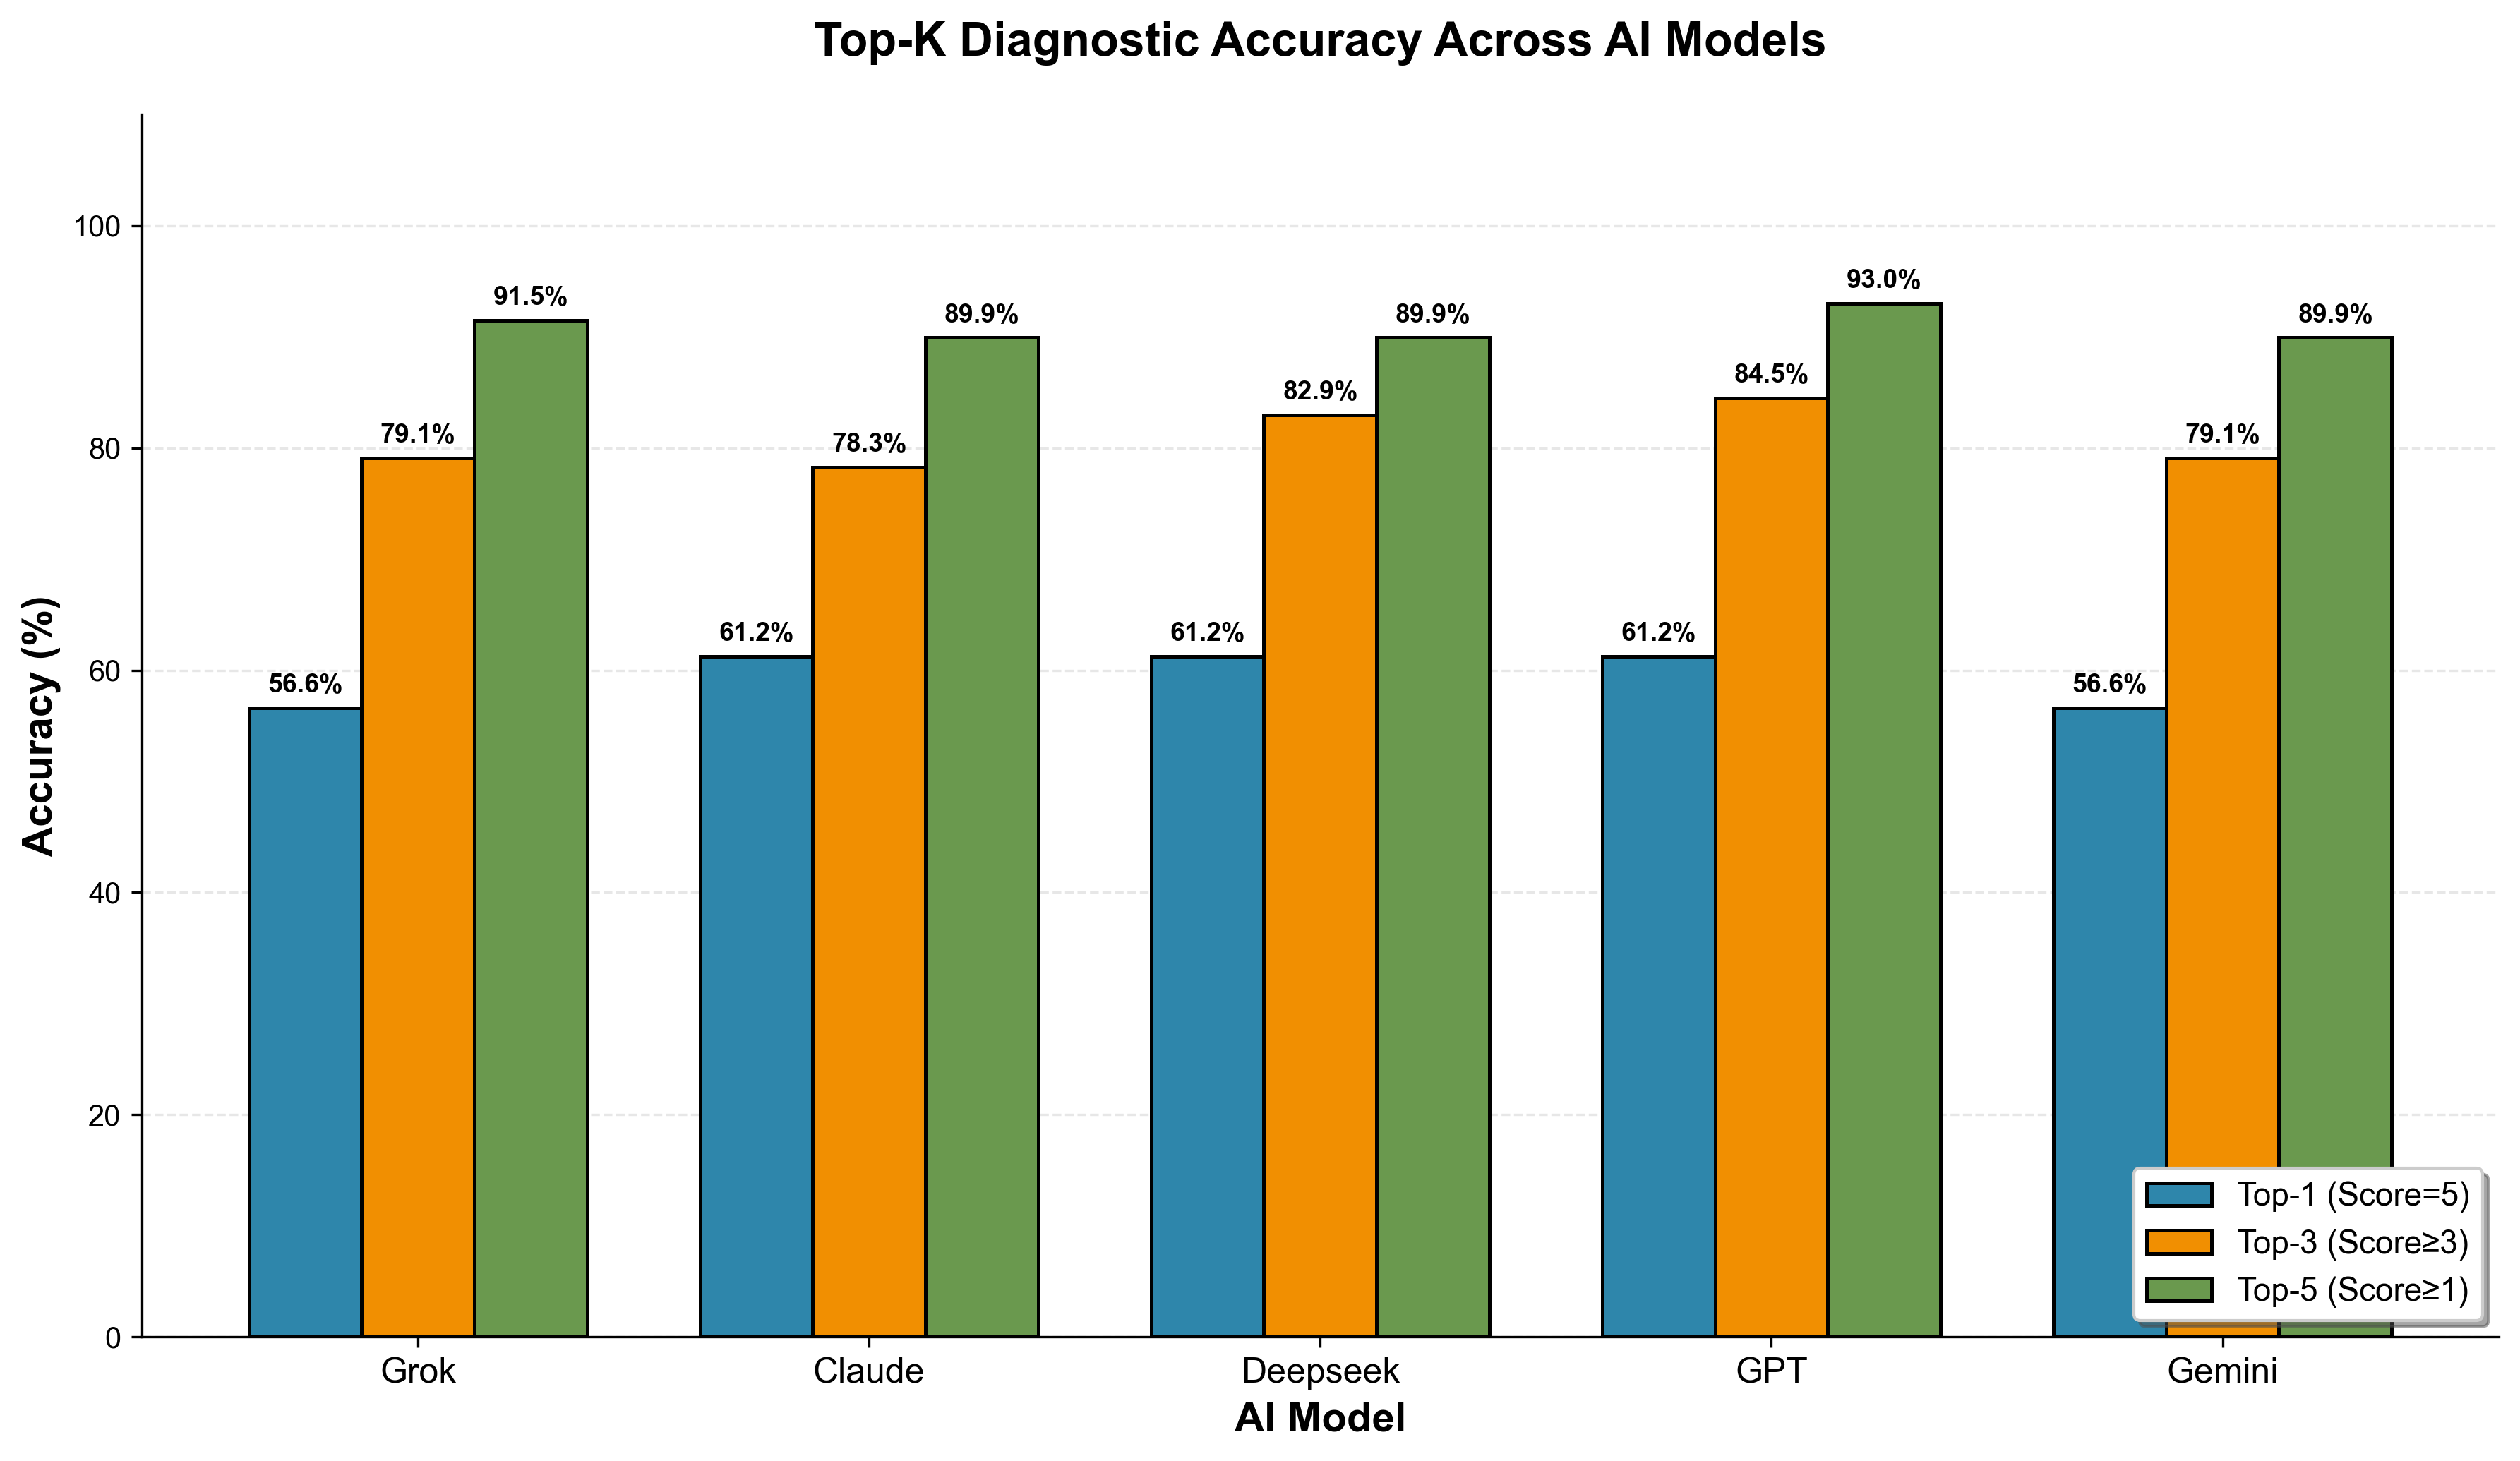

✓ Figure 2 saved: fig2_topk_accuracy.png/.pdf


In [11]:
# Publication-ready grouped bar plot for Top-K accuracy
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]

x_pos = np.arange(len(model_names))
width = 0.25

# Create grouped bars
bars1 = ax.bar(x_pos - width, top1_pct, width, label='Top-1 (Score=5)', 
               color='#2E86AB', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x_pos, top3_pct, width, label='Top-3 (Score≥3)', 
               color='#F18F01', edgecolor='black', linewidth=1.2)
bars3 = ax.bar(x_pos + width, top5_pct, width, label='Top-5 (Score≥1)', 
               color='#6A994E', edgecolor='black', linewidth=1.2)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Model', fontsize=14, fontweight='bold')
ax.set_title('Top-K Diagnostic Accuracy Across AI Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, 110)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('fig2_topk_accuracy.png', dpi=300, bbox_inches='tight')
plt.savefig('fig2_topk_accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: fig2_topk_accuracy.png/.pdf")

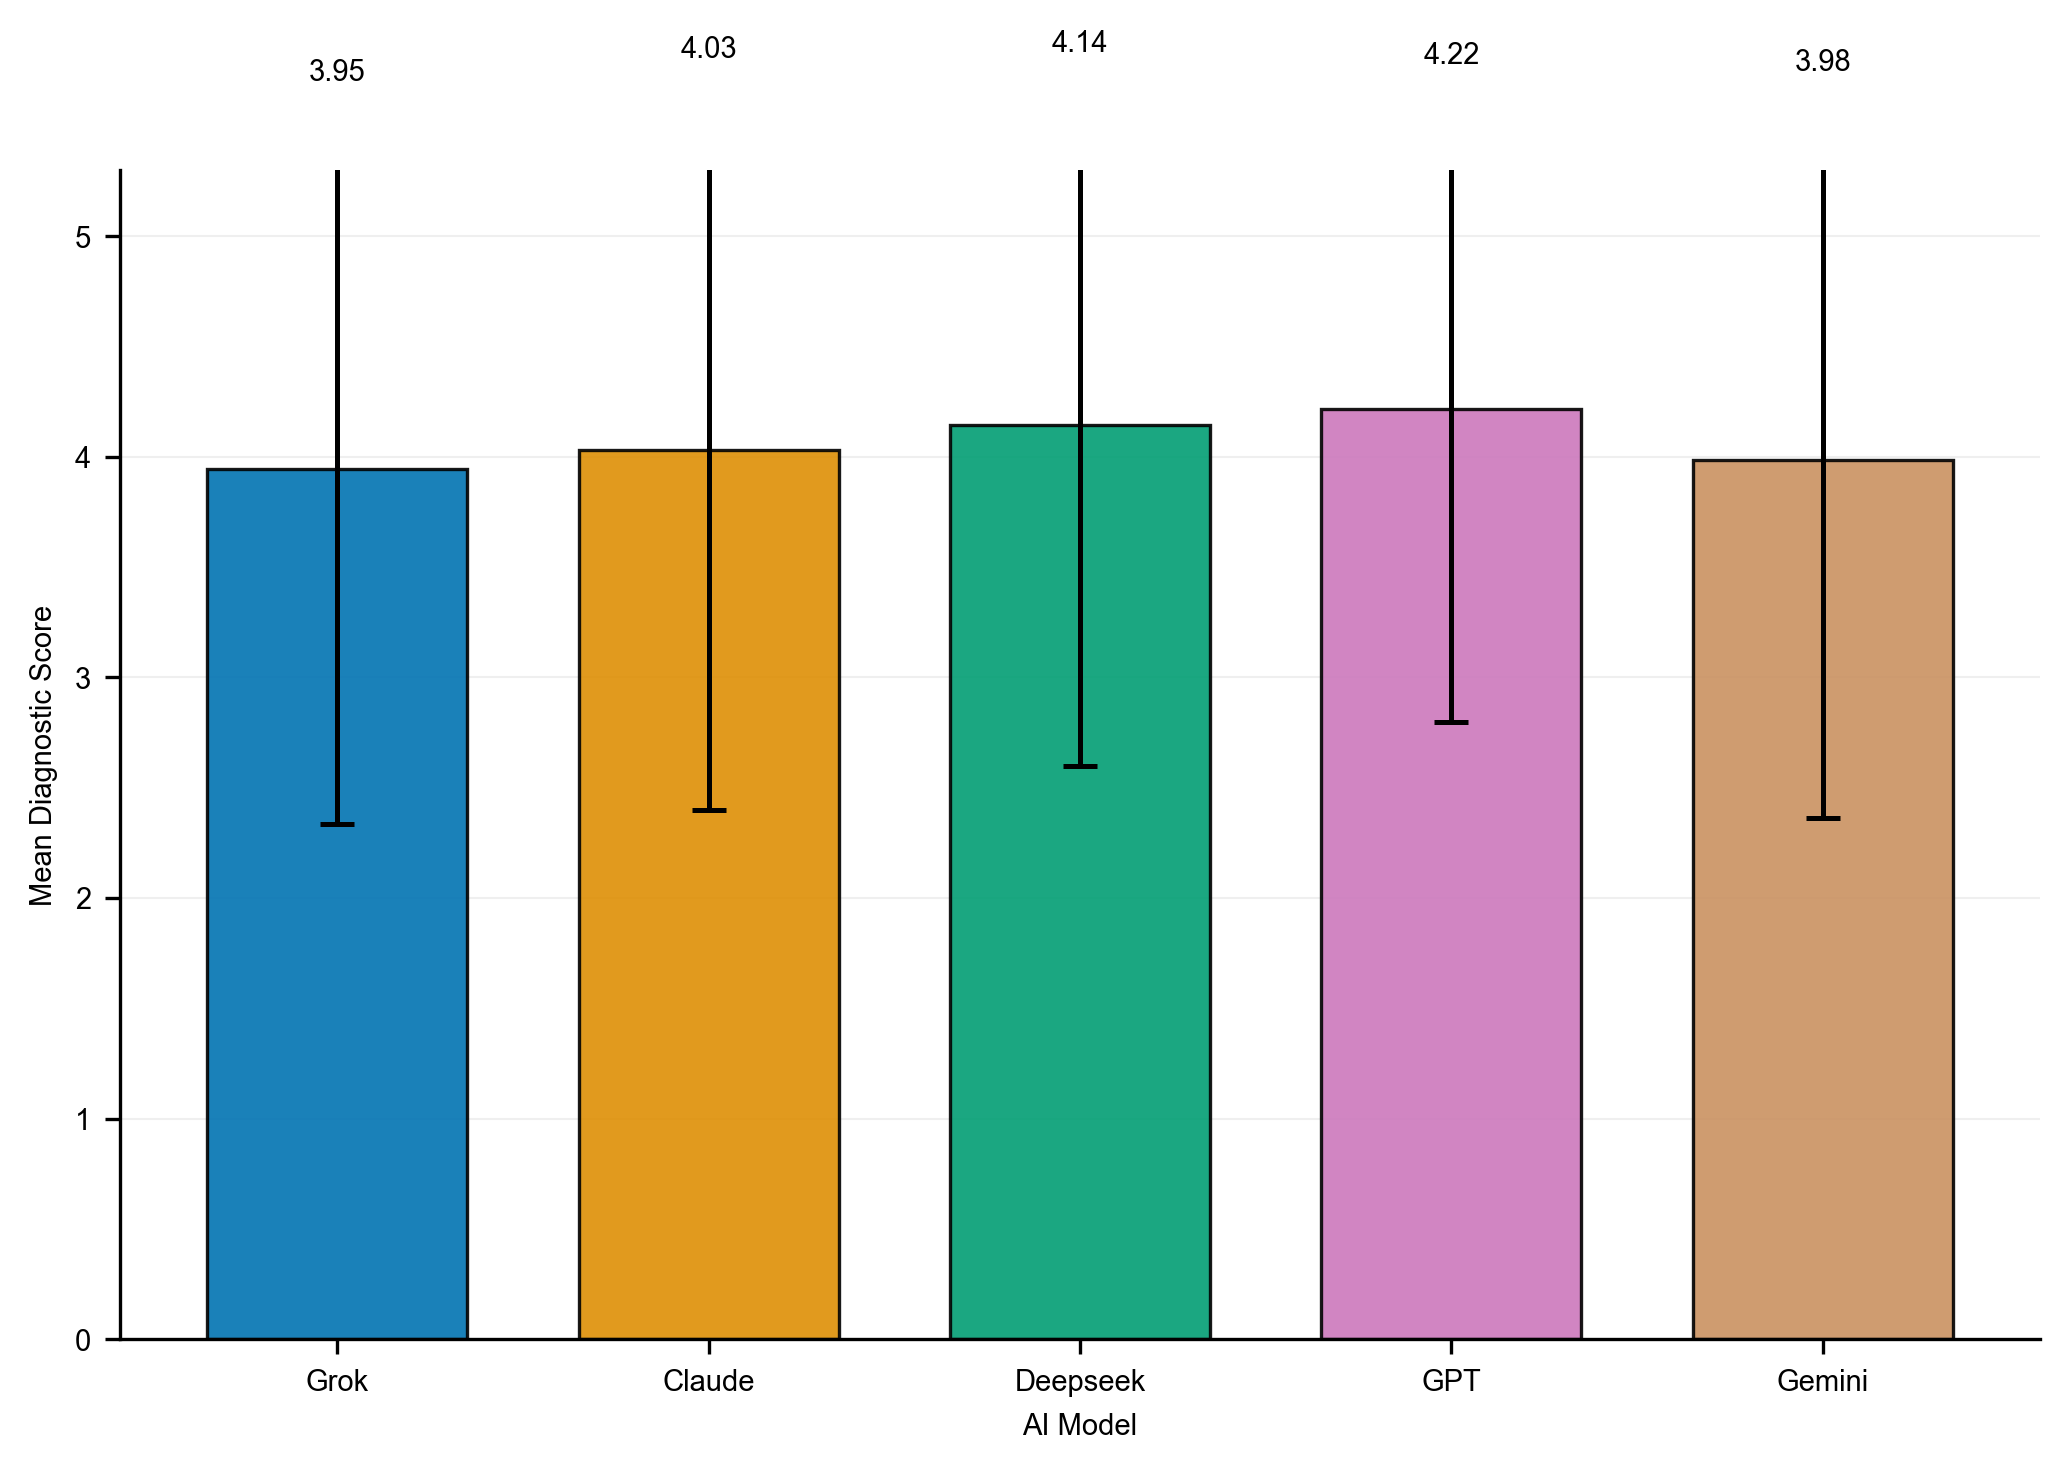

✓ Figure 1 saved: Figure1_mean_scores (PNG, PDF, TIFF at 600 DPI)


In [12]:
# NPJ Digital Medicine compliant figure - Mean scores
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7, 5))  # ~180mm width

# Data
mean_scores = [human_avg[model].mean() for model in model_names]
std_scores = [human_avg[model].std() for model in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

# Create bars
x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, mean_scores, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add error bars (SD)
ax.errorbar(x_pos, mean_scores, yerr=std_scores, fmt='none', 
            ecolor='black', capsize=4, capthick=1.2, linewidth=1.2, zorder=10)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, mean_scores, std_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.12,
            f'{mean:.2f}', ha='center', va='bottom', fontsize=7, 
            fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Mean Diagnostic Score', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 5.3)

# Clean professional styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Figure1_mean_scores.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure1_mean_scores.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure1_mean_scores.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 1 saved: Figure1_mean_scores (PNG, PDF, TIFF at 600 DPI)")

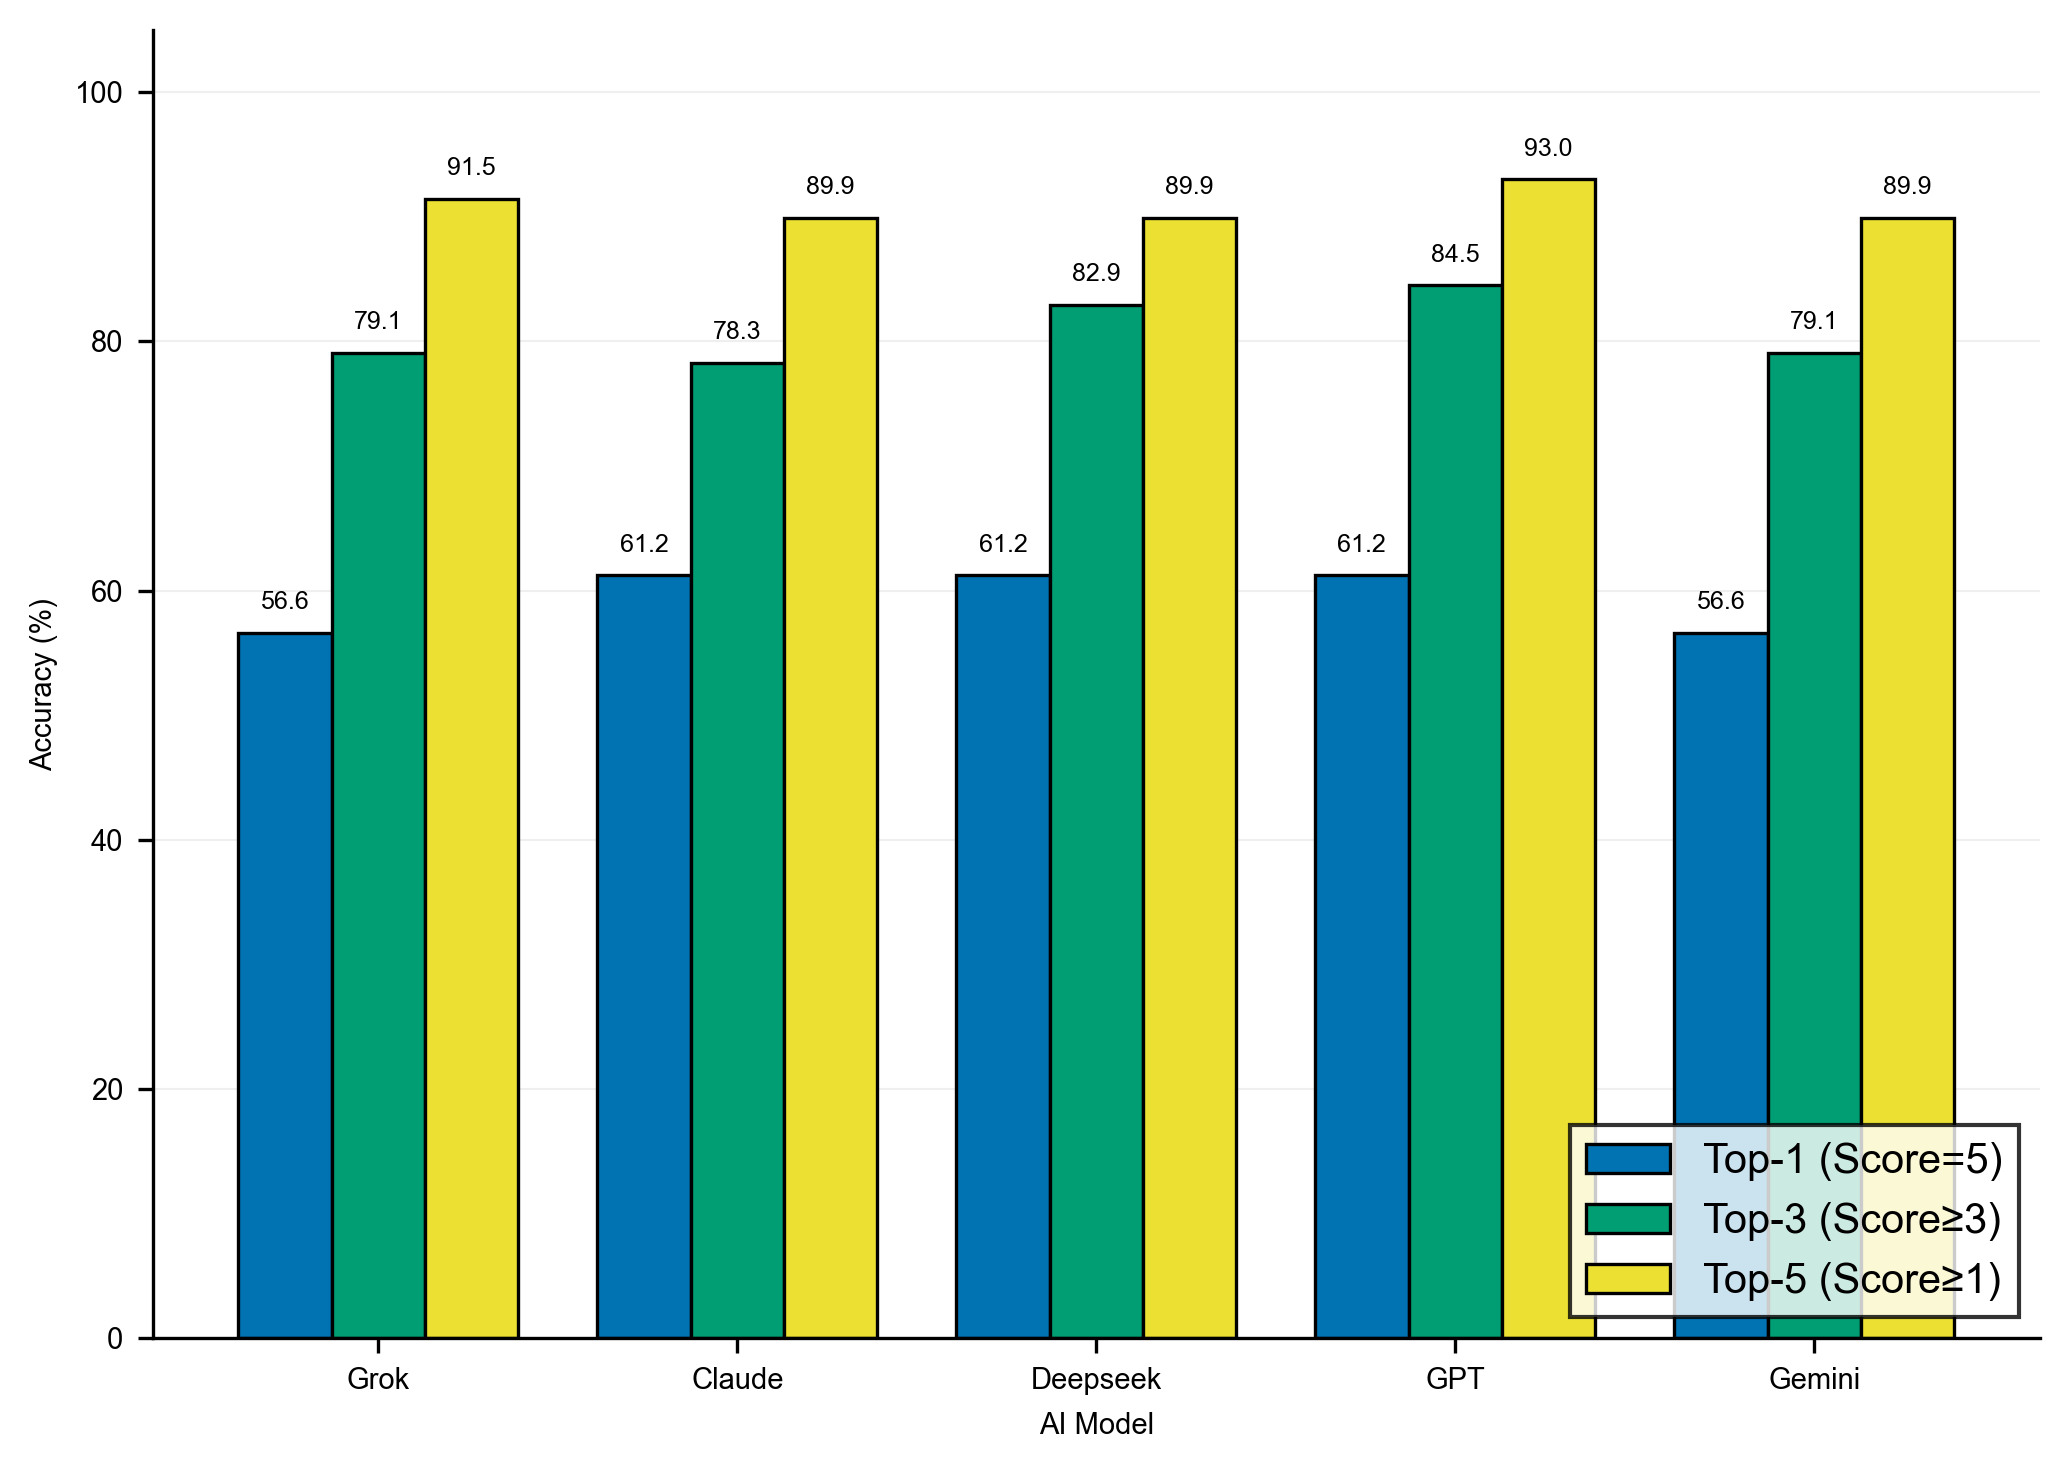

✓ Figure 2 saved: Figure2_topk_accuracy (PNG, PDF, TIFF at 600 DPI)


In [13]:
# NPJ Digital Medicine compliant figure - Top-K Accuracy
fig, ax = plt.subplots(figsize=(7, 5))

# Data
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]

x_pos = np.arange(len(model_names))
width = 0.26

# Nature color palette
colors_topk = ['#0173B2', '#029E73', '#ECE133']

# Create grouped bars
bars1 = ax.bar(x_pos - width, top1_pct, width, label='Top-1 (Score=5)', 
               color=colors_topk[0], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x_pos, top3_pct, width, label='Top-3 (Score≥3)', 
               color=colors_topk[1], edgecolor='black', linewidth=0.8)
bars3 = ax.bar(x_pos + width, top5_pct, width, label='Top-5 (Score≥1)', 
               color=colors_topk[2], edgecolor='black', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                f'{height:.1f}', ha='center', va='bottom', 
                fontsize=6, fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.legend(loc='lower right', fontsize=6, frameon=True, edgecolor='black', 
          fancybox=False, shadow=False, prop={'family': 'Arial'})
ax.set_ylim(0, 105)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Figure2_topk_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: Figure2_topk_accuracy (PNG, PDF, TIFF at 600 DPI)")

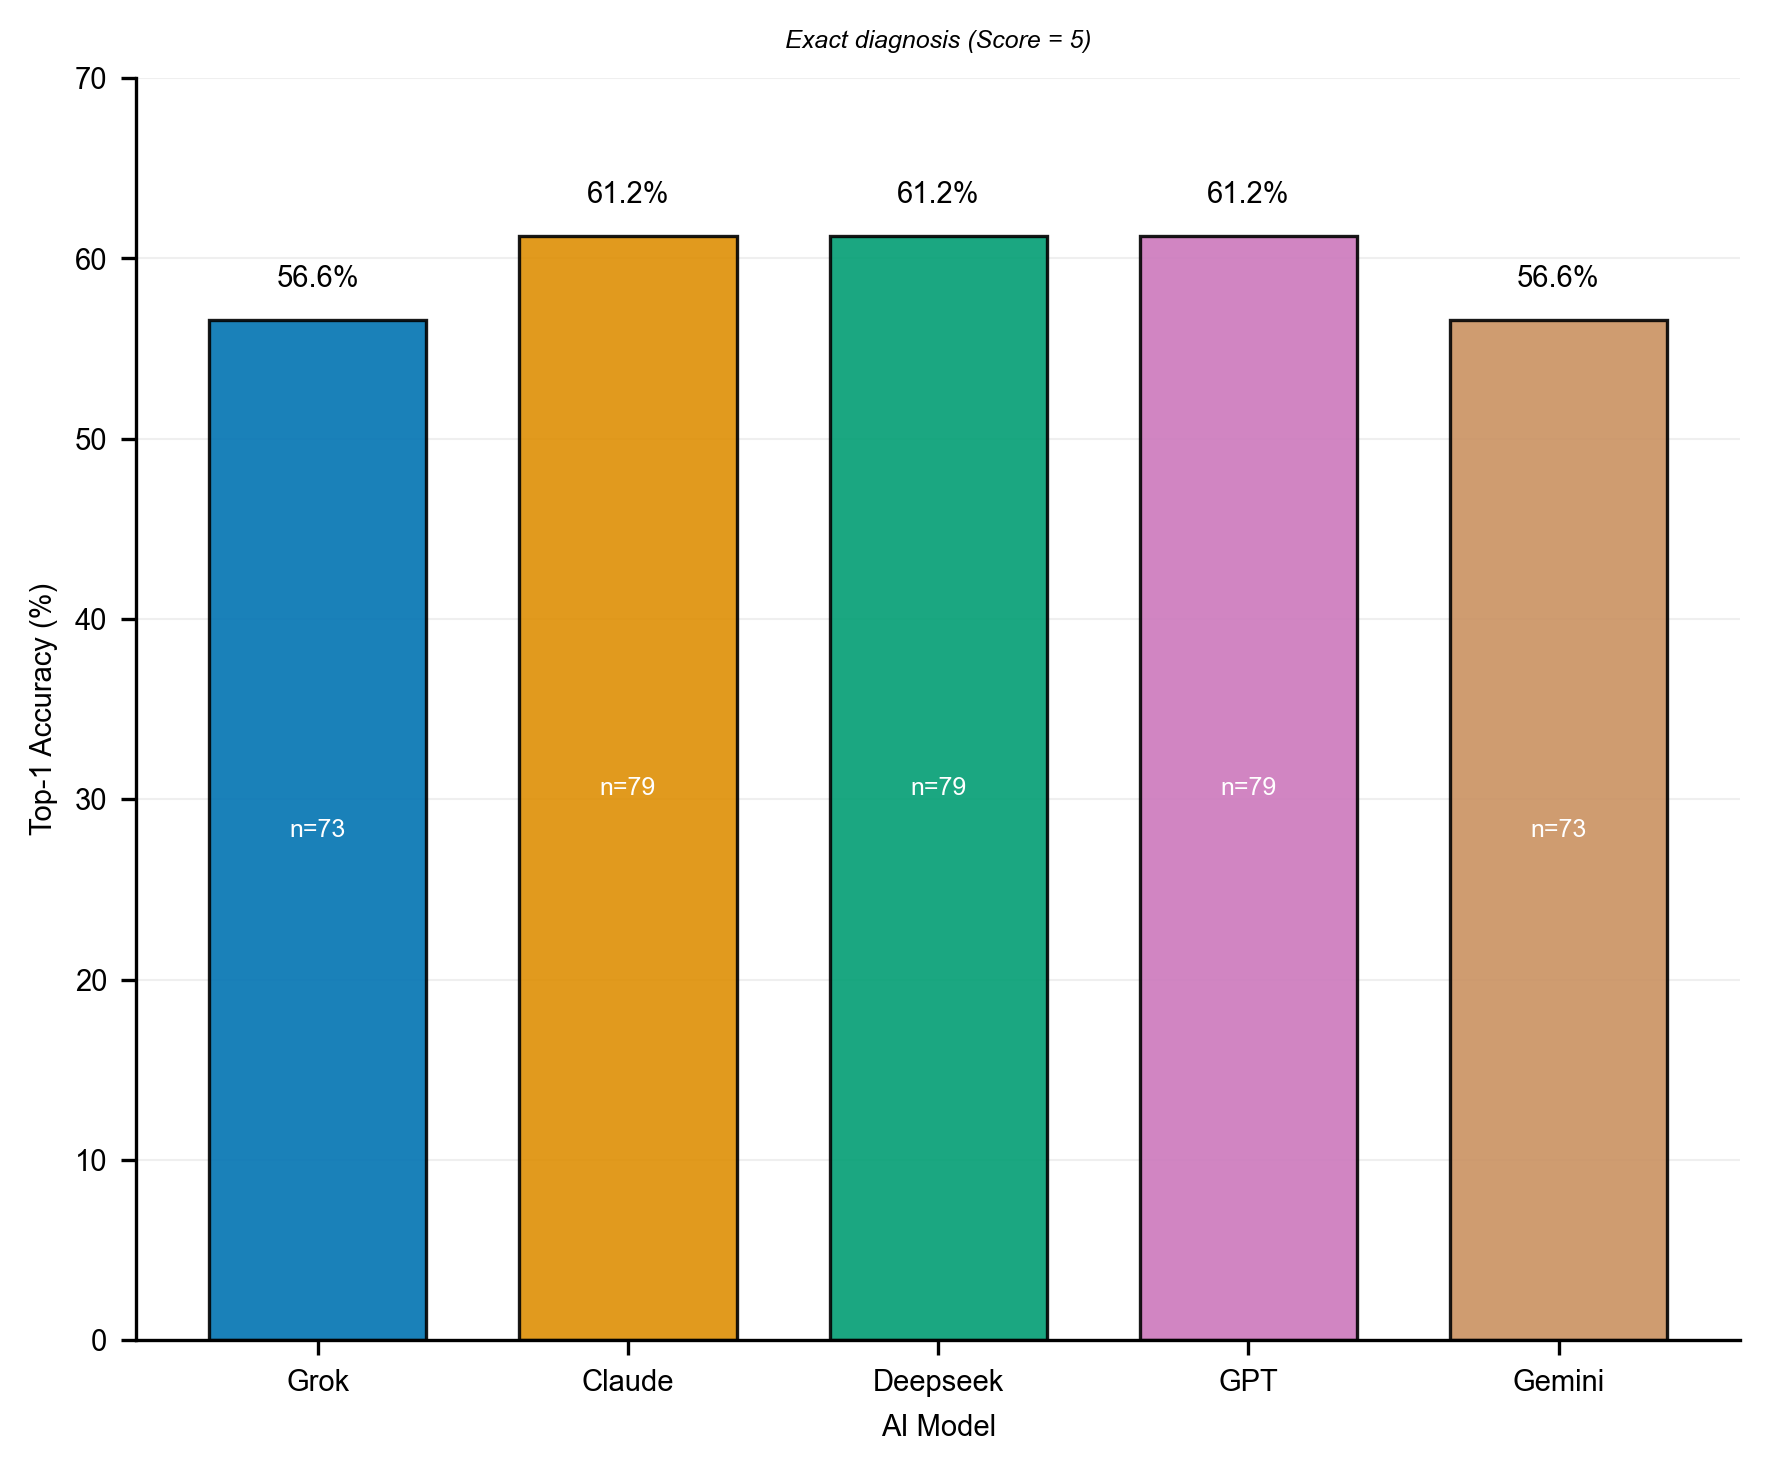

✓ Figure 2a saved: Figure2a_top1_accuracy (Score=5)


In [14]:
# NPJ Digital Medicine compliant - Top-1 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-1 only
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top1_count = [topk_df[topk_df['Model']==m]['Top-1 (Score=5)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top1_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top1_pct, top1_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 70)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Exact diagnosis (Score = 5)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2a_top1_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2a_top1_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2a_top1_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2a saved: Figure2a_top1_accuracy (Score=5)")

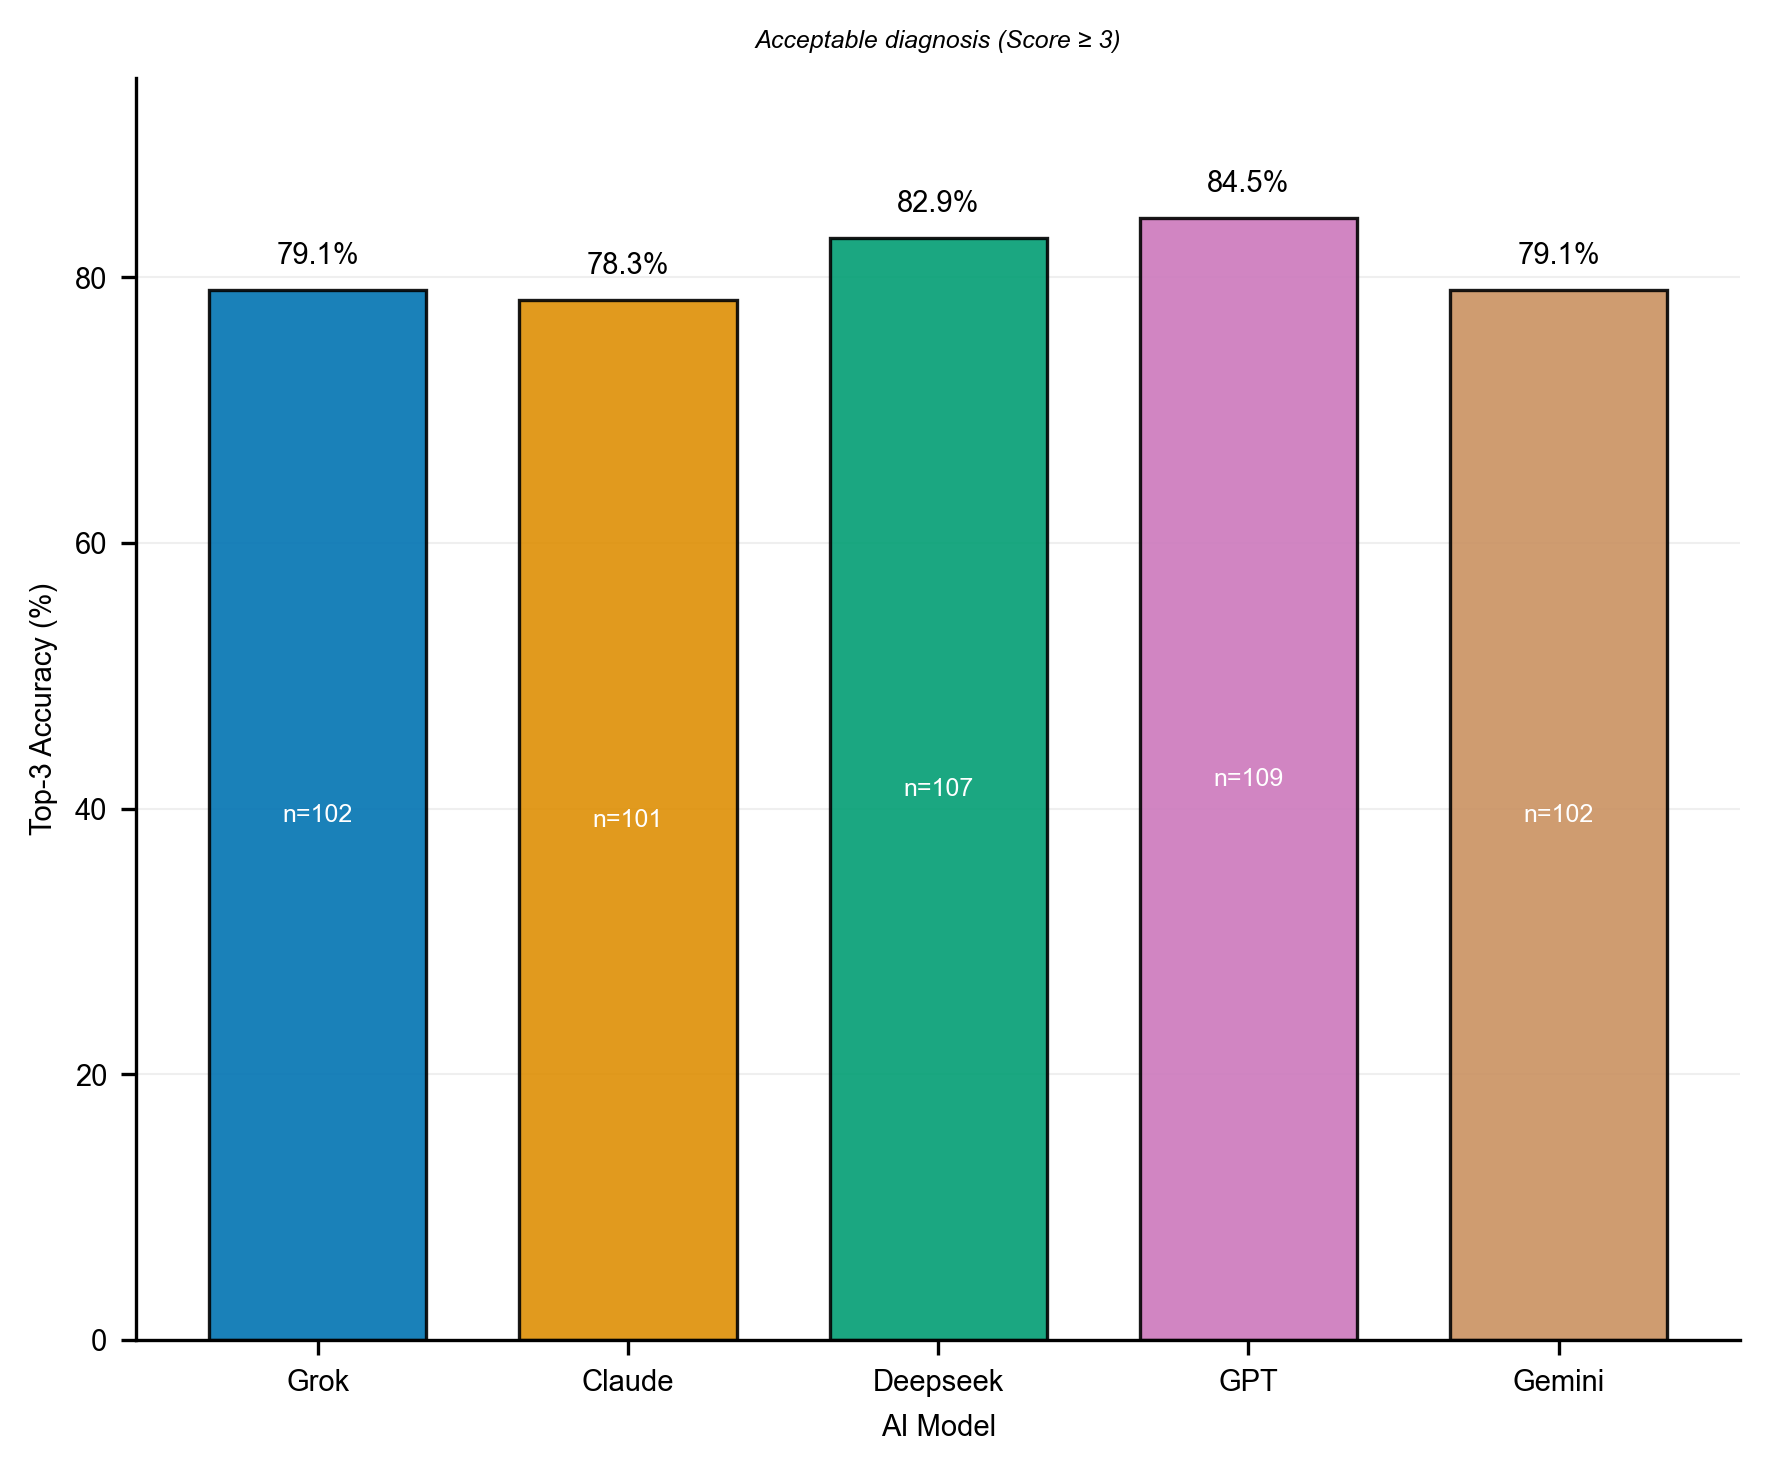

✓ Figure 2b saved: Figure2b_top3_accuracy (Score≥3)


In [15]:
# NPJ Digital Medicine compliant - Top-3 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-3 only
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top3_count = [topk_df[topk_df['Model']==m]['Top-3 (Score>=3)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top3_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top3_pct, top3_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-3 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 95)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Acceptable diagnosis (Score ≥ 3)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2b_top3_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2b_top3_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2b_top3_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2b saved: Figure2b_top3_accuracy (Score≥3)")

In [19]:
# %%
import os
print("Current working directory:")
print(os.getcwd())

print("\nFiles currently in this directory:")
print(os.listdir(os.getcwd()))


Current working directory:
d:\Sleep_medicine\sleep

Files currently in this directory:
['book_Book_failure_heatmap.png', 'book_Book_failure_rate.png', 'book_Book_mean_heatmap.png', 'book_Book_mean_scores.png', 'book_Book_top1.png', 'case_difficulty_distribution.png', 'co_failure_heatmap.png', 'demographics_results.xlsx', 'diagnostic_performance_results.xlsx', 'error_analysis_results.xlsx', 'failure_analysis_results.xlsx', 'failure_distribution_across_models.png', 'failure_heatmap_by_source.png', 'failure_rate_by_domain.png', 'failure_rate_by_model.png', 'failure_rate_by_source.png', 'fig1_mean_scores_comparison.pdf', 'fig1_mean_scores_comparison.png', 'fig2_topk_accuracy.pdf', 'fig2_topk_accuracy.png', 'Figure1_mean_scores.pdf', 'Figure1_mean_scores.png', 'Figure1_mean_scores.tiff', 'Figure2a_top1_accuracy.pdf', 'Figure2a_top1_accuracy.png', 'Figure2a_top1_accuracy.tiff', 'Figure2b_top3_accuracy.pdf', 'Figure2b_top3_accuracy.png', 'Figure2b_top3_accuracy.tiff', 'Figure2_topk_accuracy.p

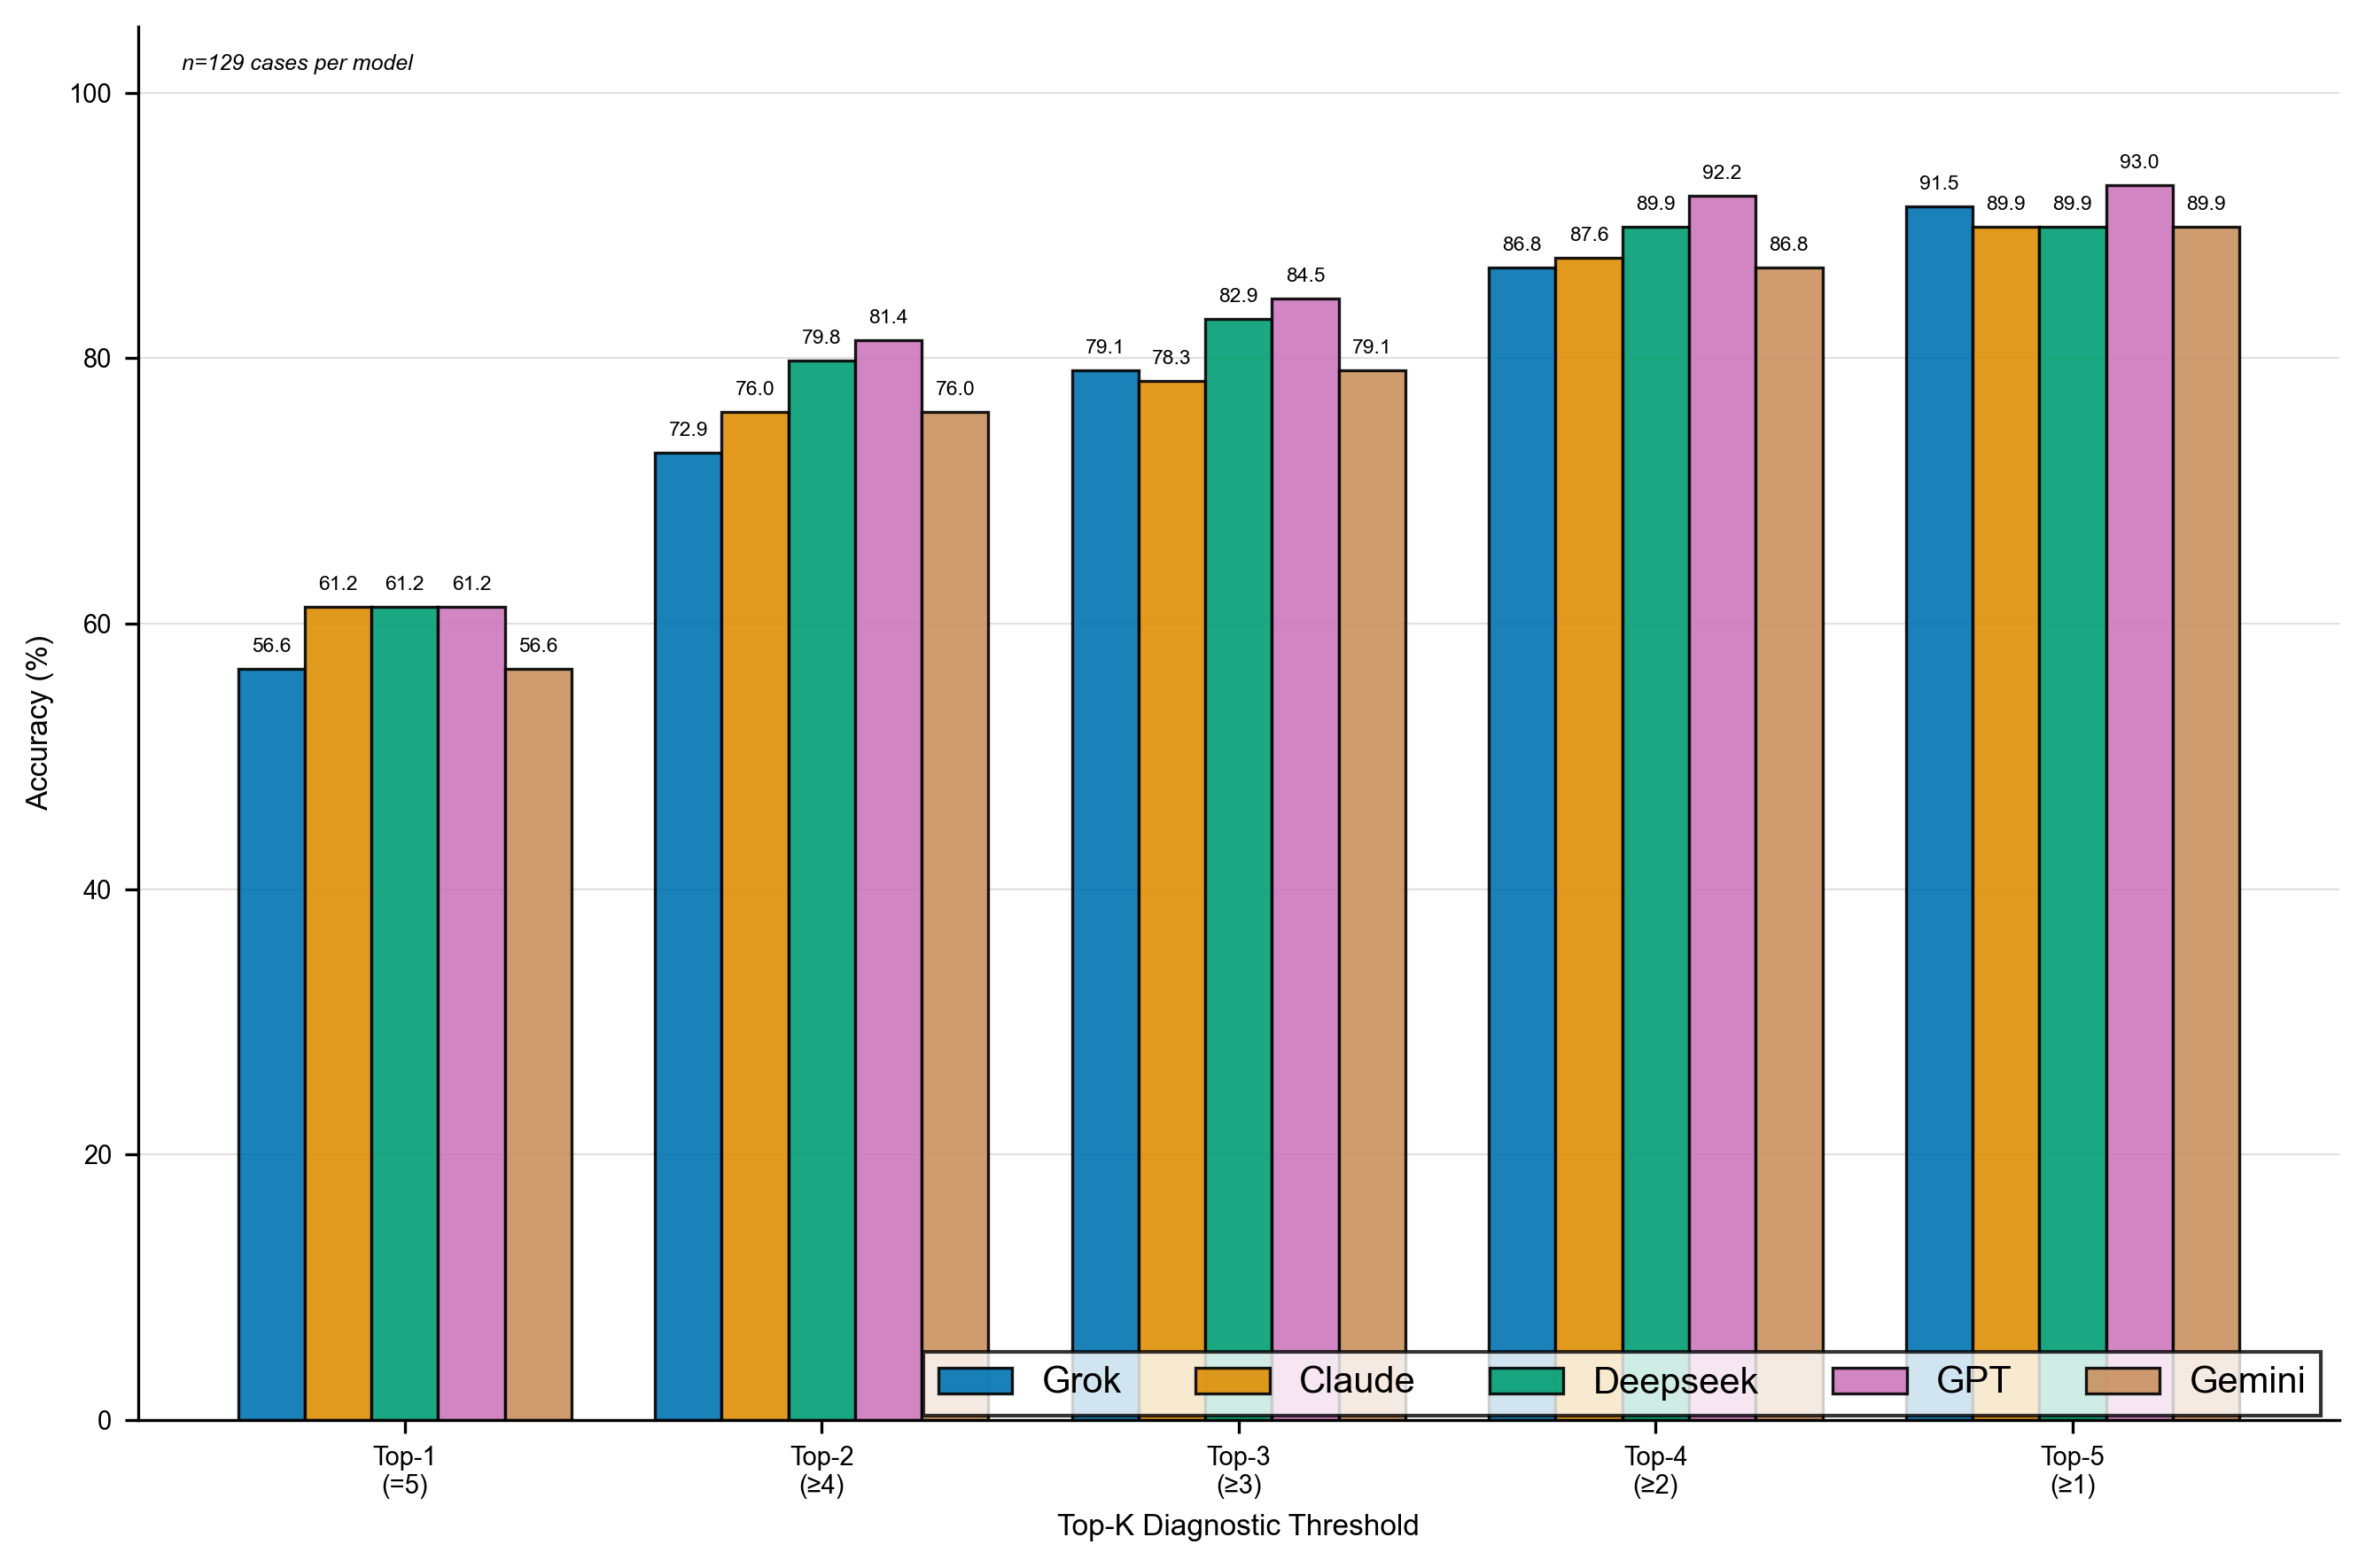

✓ Figure 2 saved: Comprehensive Top-K threshold rates by model
  Models compared: Grok, Claude, Deepseek, GPT, Gemini
  Metrics: Top-1 through Top-5


In [11]:
# NPJ Digital Medicine compliant - Comprehensive Top-K threshold rates
fig, ax = plt.subplots(figsize=(9, 6))

# Prepare comprehensive Top-K data
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

# Calculate all Top-K rates
topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,  # Top-1
        (scores >= 4).sum() / n_total * 100,  # Top-2
        (scores >= 3).sum() / n_total * 100,  # Top-3
        (scores >= 2).sum() / n_total * 100,  # Top-4
        (scores >= 1).sum() / n_total * 100,  # Top-5
    ]

# Professional Nature color palette (colorblind-friendly)
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# Set up positions
x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

# Plot bars for each model
bars_list = []
for i, model in enumerate(model_names):
    bars = ax.bar(x + offsets[i], topk_data[model], width, 
                  label=model, color=colors[model], 
                  edgecolor='black', linewidth=0.8, alpha=0.9)
    bars_list.append(bars)
    
    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1.0,
                f'{topk_data[model][j]:.1f}',
                ha='center', va='bottom', fontsize=5.5, 
                fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Accuracy (%)', fontsize=8, fontweight='normal', family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, fontweight='normal', family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 105)

# Legend
ax.legend(loc='lower right', fontsize=7, frameon=True, 
          edgecolor='black', fancybox=False, shadow=False, 
          prop={'family': 'Arial'}, ncol=5, 
          bbox_to_anchor=(1.0, -0.01))

# Clean professional styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.25, linewidth=0.5, color='gray')
ax.set_axisbelow(True)

# Add sample size annotation
ax.text(0.02, 0.98, 'n=129 cases per model', 
        transform=ax.transAxes, fontsize=6, 
        va='top', ha='left', family='Arial', style='italic')

plt.tight_layout()
plt.savefig('Figure2_topk_comprehensive.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_comprehensive.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_comprehensive.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: Comprehensive Top-K threshold rates by model")
print(f"  Models compared: {', '.join(model_names)}")
print(f"  Metrics: Top-1 through Top-5")

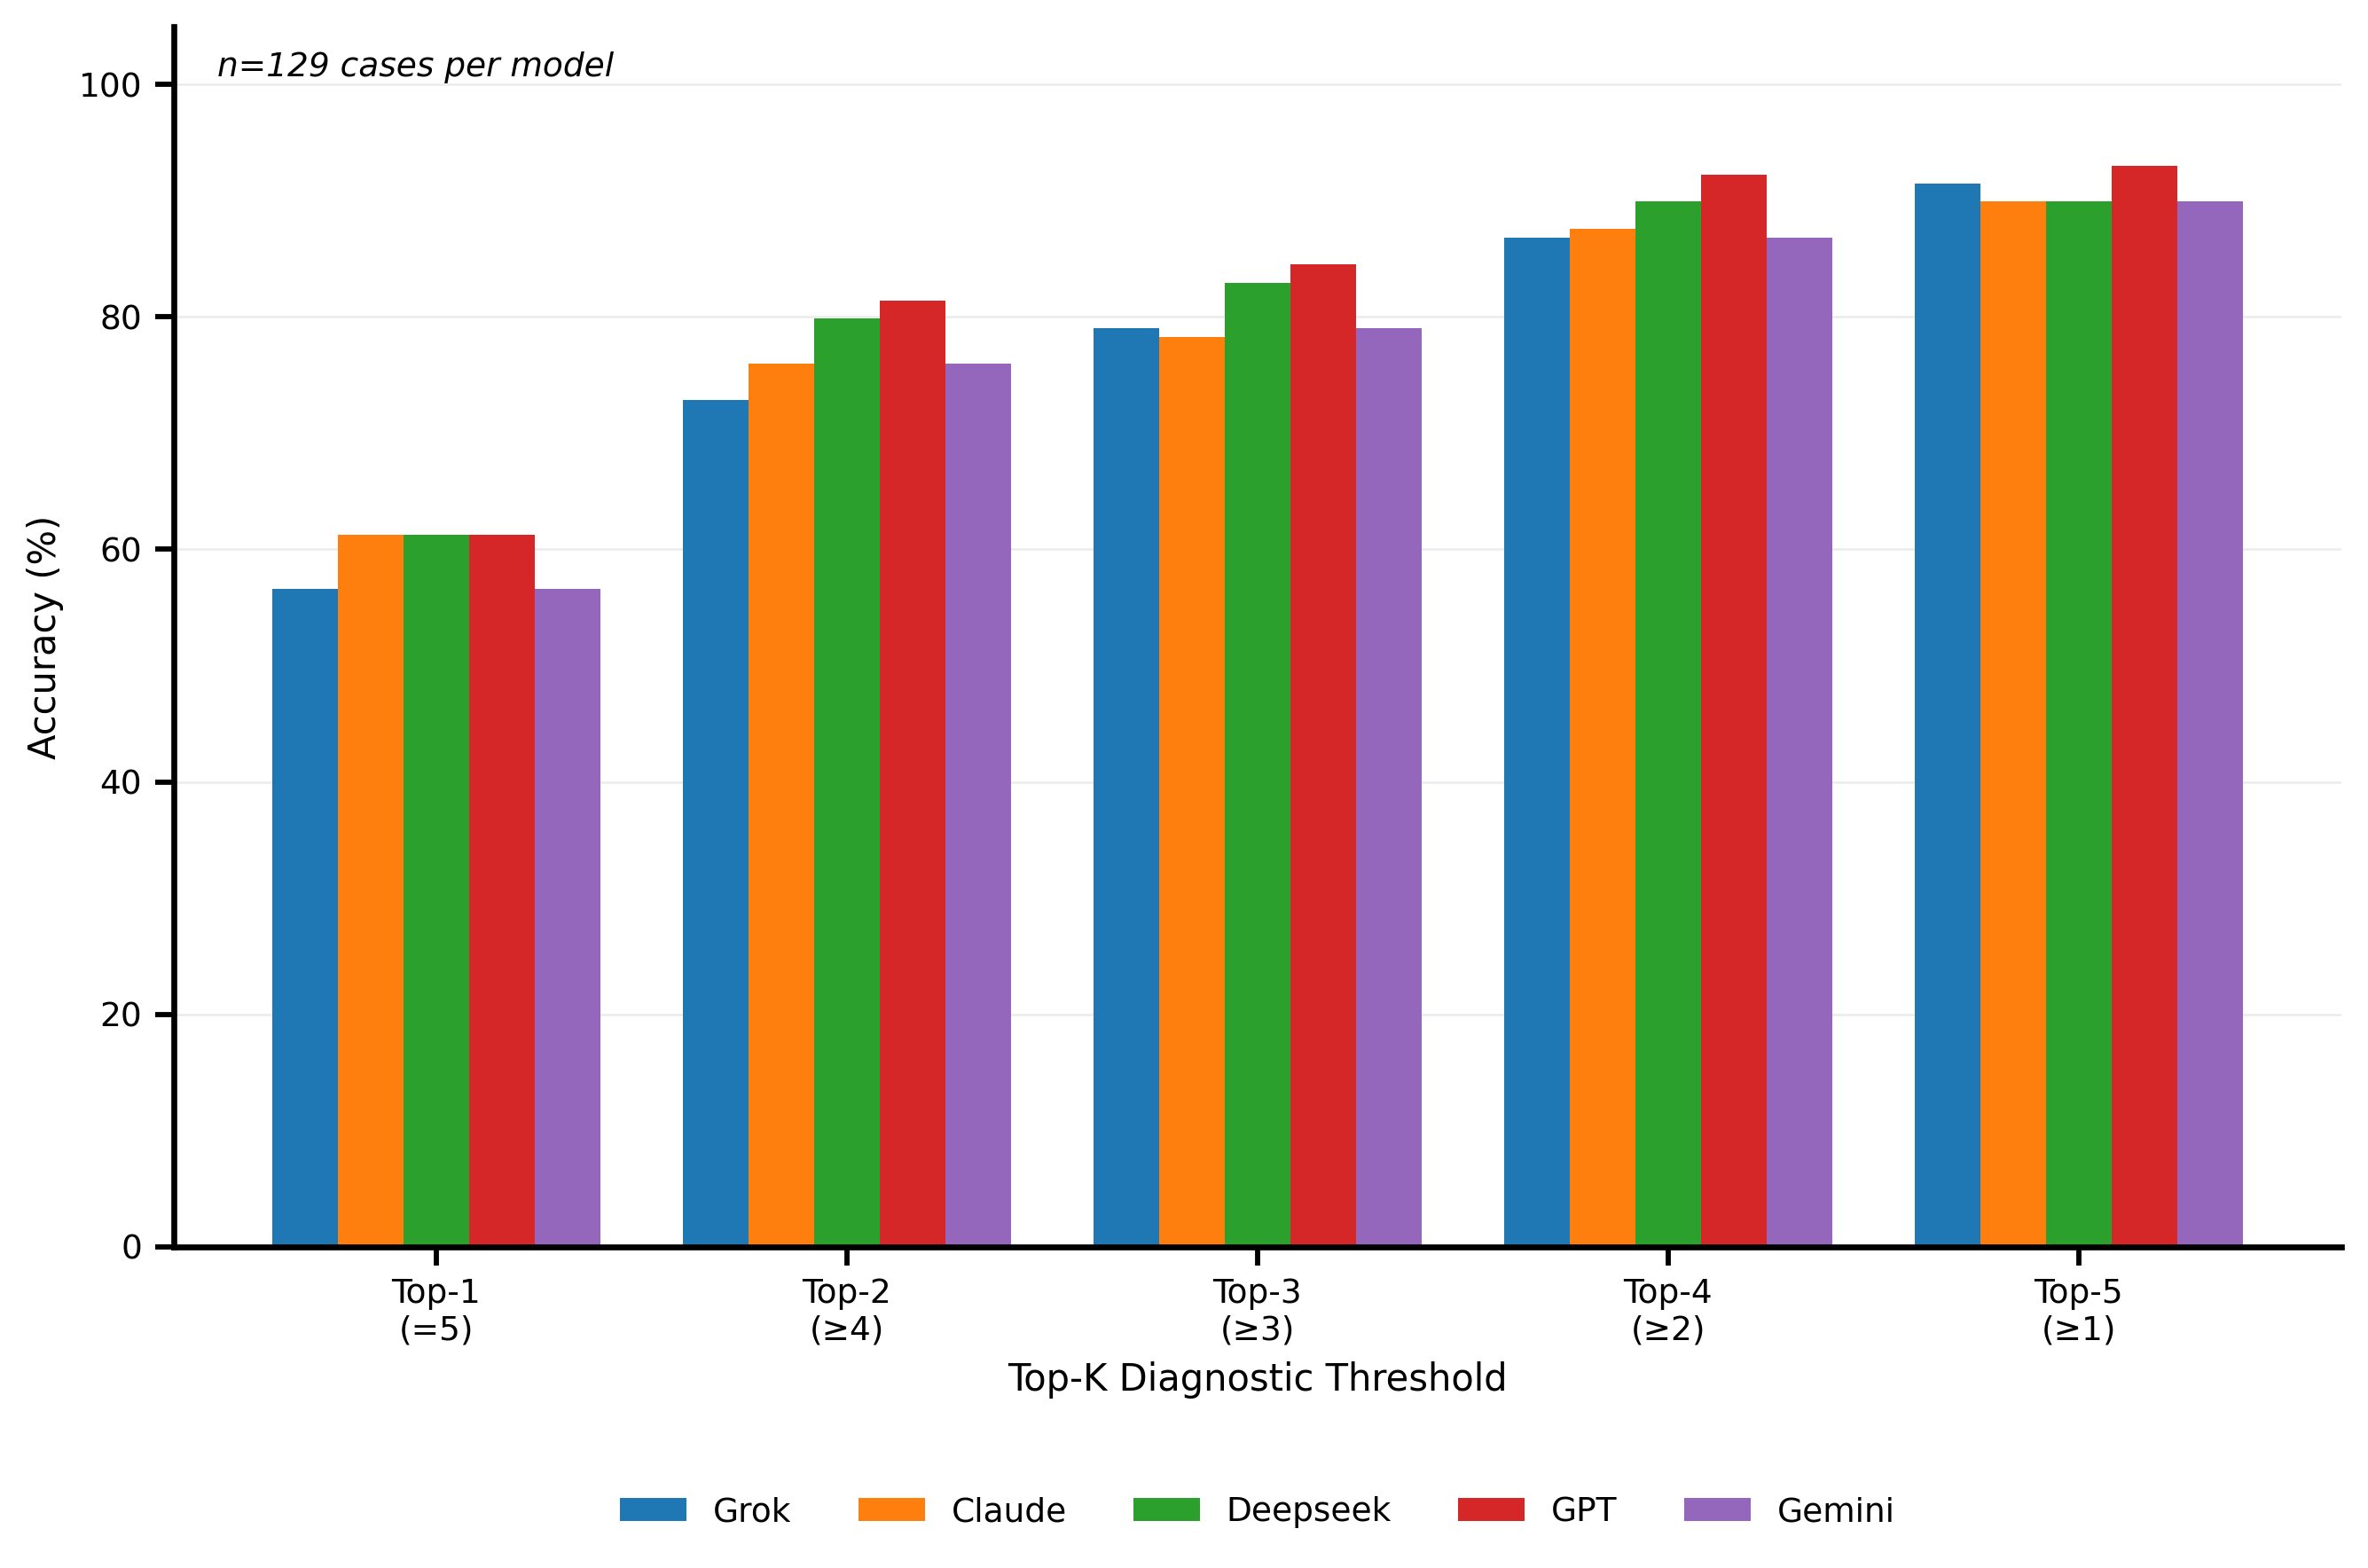

Saved files:
PNG : d:\sleep_final\figures\Figure2_topk_comprehensive.png | exists: True
PDF : d:\sleep_final\figures\Figure2_topk_comprehensive.pdf | exists: True
TIFF: d:\sleep_final\figures\Figure2_topk_comprehensive.tiff | exists: True


In [12]:
# %%
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Match the reference palette (Matplotlib tab10) ---
# Grok (blue), Claude (orange), DeepSeek (green), GPT (red), Gemini (purple)
COLORS = {
    "Grok":   "#1f77b4",
    "Claude": "#ff7f0e",
    "Deepseek": "#2ca02c",   # keep your key spelling
    "GPT":    "#d62728",
    "Gemini": "#9467bd",
}

# --- 2) Global style to mimic the screenshot ---
plt.rcParams.update({
    "font.family": "DejaVu Sans",      # close to the screenshot; use Arial if you have it installed
    "axes.titlesize": 11,
    "axes.titleweight": "bold",
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

# Prepare Top-K data
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,  # Top-1
        (scores >= 4).sum() / n_total * 100,  # Top-2
        (scores >= 3).sum() / n_total * 100,  # Top-3
        (scores >= 2).sum() / n_total * 100,  # Top-4
        (scores >= 1).sum() / n_total * 100,  # Top-5
    ]

# --- 3) Plot ---
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=COLORS.get(model, None),
        edgecolor="none",      # IMPORTANT: no black borders (matches reference)
        linewidth=0,
        alpha=1.0
    )

# Axes labels/ticks
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Top-K Diagnostic Threshold")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 105)

# Grid + spines to match reference
ax.grid(axis="y", linewidth=0.6, alpha=0.25)     # subtle horizontal grid
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.6)
ax.spines["bottom"].set_linewidth(1.6)

ax.tick_params(axis="both", width=1.4, length=5)

# Legend at bottom center (like the photo)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False
)

# Sample size annotation (top-left inside plot)
ax.text(
    0.02, 0.98,
    f"n={len(human_avg[model_names[0]].dropna())} cases per model",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9,
    style="italic"
)

plt.tight_layout()

# --- 4) Save robustly (absolute path + check) ---
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

png_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.png")
pdf_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.pdf")
tiff_path = os.path.join(out_dir, "Figure2_topk_comprehensive.tiff")

fig.savefig(png_path,  dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(pdf_path,  dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(tiff_path, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("Saved files:")
print("PNG :", png_path,  "| exists:", os.path.exists(png_path))
print("PDF :", pdf_path,  "| exists:", os.path.exists(pdf_path))
print("TIFF:", tiff_path, "| exists:", os.path.exists(tiff_path))


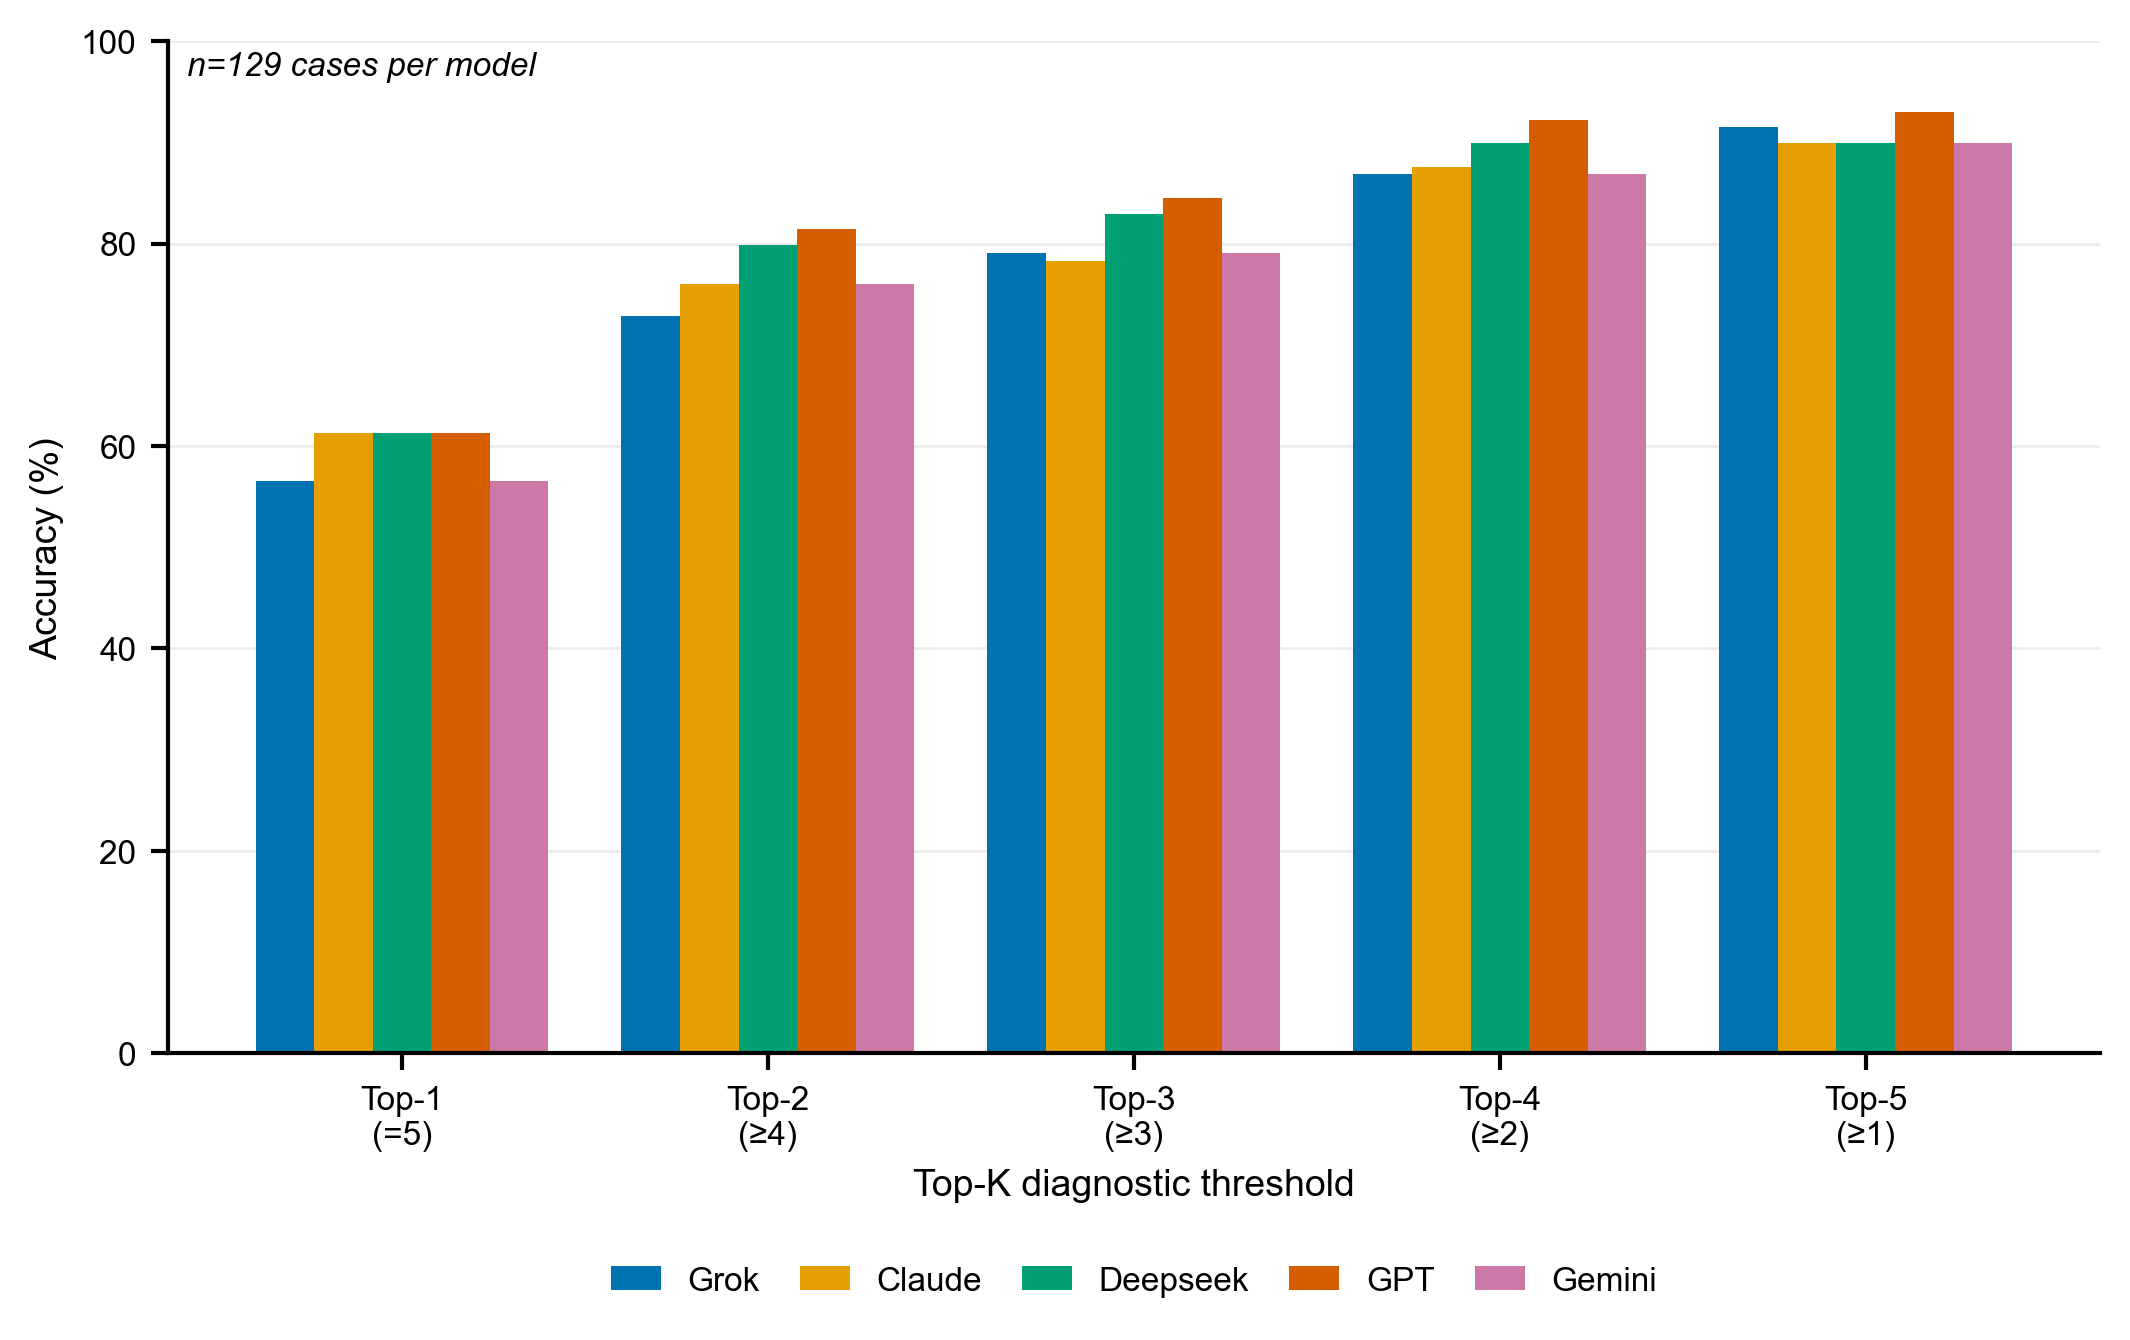

Saved files:
 PNG : d:\sleep_final\figures\Figure2_topk_comprehensive.png | exists: True
 PDF : d:\sleep_final\figures\Figure2_topk_comprehensive.pdf | exists: True
 TIFF: d:\sleep_final\figures\Figure2_topk_comprehensive.tiff | exists: True


In [13]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score  # (not used here, but keeping if in your notebook)

# ----------------------------
# 1) Nature/NPJ-friendly rcParams
# ----------------------------
mpl.rcParams.update({
    # Use a clear sans-serif font; matplotlib will fall back if Arial isn't installed
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],

    # Embed TrueType fonts in PDF/PS (Nature figure guide suggests pdf.fonttype=42)
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    # Clean axes
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
})

# ----------------------------
# 2) Color palette (Okabe–Ito-inspired, colorblind-friendly)
#    Avoids "pure" red/green reliance and stays clean in print.
# ----------------------------
COLORS = {
    "Grok":    "#0072B2",  # blue
    "Claude":  "#E69F00",  # orange
    "Deepseek":"#009E73",  # bluish-green (teal)
    "GPT":     "#D55E00",  # vermillion (more print-safe than pure red)
    "Gemini":  "#CC79A7",  # reddish-purple
}

# ----------------------------
# 3) Compute Top-K data
# ----------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
n_per_model = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    n_per_model[model] = n_total
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,
        (scores >= 4).sum() / n_total * 100,
        (scores >= 3).sum() / n_total * 100,
        (scores >= 2).sum() / n_total * 100,
        (scores >= 1).sum() / n_total * 100,
    ]

# ----------------------------
# 4) Plot (clean, NPJ-like)
# ----------------------------
fig, ax = plt.subplots(figsize=(7.2, 4.6))  # a bit more journal-like than 9x6; adjust as needed

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=COLORS.get(model, "#333333"),
        edgecolor="none",      # avoid heavy outlines/boxing
        linewidth=0.0
    )

# Labels/ticks
ax.set_ylabel("Accuracy (%)", fontsize=9)
ax.set_xlabel("Top-K diagnostic threshold", fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=8)
ax.tick_params(axis="y", labelsize=8)

ax.set_ylim(0, 100)

# Subtle grid (NPJ-friendly: no heavy decoration)
ax.yaxis.grid(True, linewidth=0.6, alpha=0.25)
ax.set_axisbelow(True)

# Spines: keep left/bottom, remove top/right (clean look)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optional: small note (keep minimal)
# Use a single n if consistent; otherwise show range
n_vals = list(n_per_model.values())
if len(set(n_vals)) == 1:
    note = f"n={n_vals[0]} cases per model"
else:
    note = f"n per model: {min(n_vals)}–{max(n_vals)} cases"

ax.text(
    0.01, 0.99, note,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=8, style="italic"
)

# Legend: bottom-centered, no frame (clean)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False,
    fontsize=8,
    handlelength=1.5,
    columnspacing=1.2
)

plt.tight_layout()

# ----------------------------
# 5) Save (robust paths + verify)
# ----------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

png_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.png")
pdf_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.pdf")
tiff_path = os.path.join(out_dir, "Figure2_topk_comprehensive.tiff")

# 600 dpi is fine for line/combination art; keep white bg
fig.savefig(png_path,  dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(pdf_path,  bbox_inches="tight", facecolor="white")          # vector; dpi not needed
fig.savefig(tiff_path, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("Saved files:")
print(" PNG :", png_path,  "| exists:", os.path.exists(png_path))
print(" PDF :", pdf_path,  "| exists:", os.path.exists(pdf_path))
print(" TIFF:", tiff_path, "| exists:", os.path.exists(tiff_path))


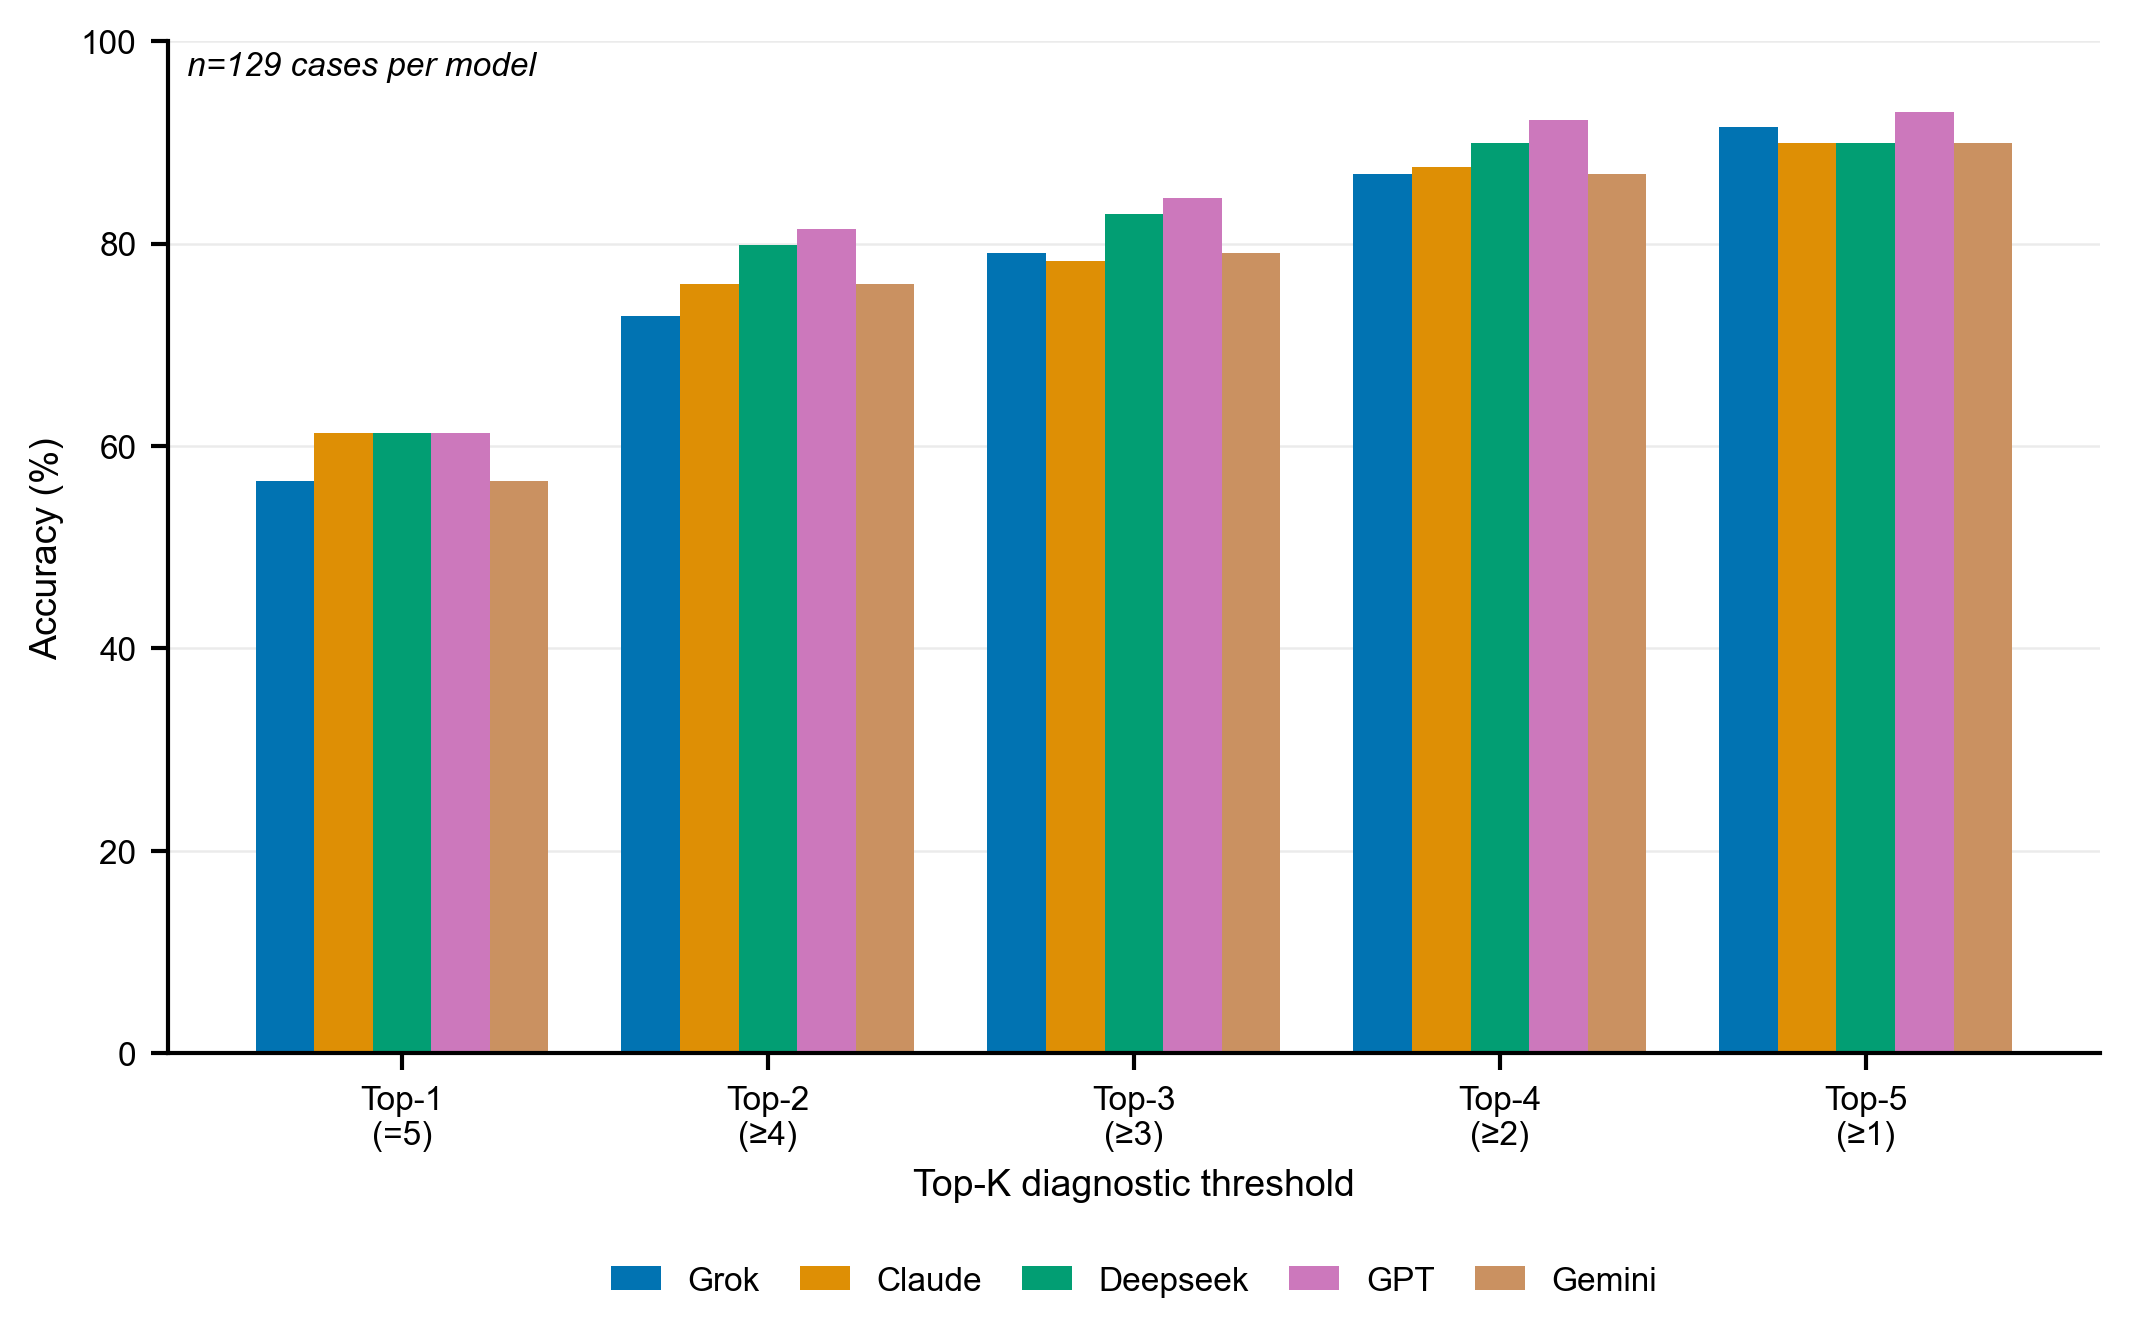

✓ Saved Figure 2 (Top-K rates) to:
 PNG : d:\sleep_final\figures\Figure2_topk_comprehensive.png | exists: True
 PDF : d:\sleep_final\figures\Figure2_topk_comprehensive.pdf | exists: True
 TIFF: d:\sleep_final\figures\Figure2_topk_comprehensive.tiff | exists: True


In [14]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# 1) NPJ/Nature-friendly defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,   # embed TrueType fonts in PDF
    "ps.fonttype": 42,
})

# -------------------------
# 2) Your exact color palette (UNCHANGED)
# -------------------------
colors = {
    "Grok": "#0173B2",
    "Claude": "#DE8F05",
    "Deepseek": "#029E73",
    "GPT": "#CC78BC",
    "Gemini": "#CA9161",
}

# -------------------------
# 3) Compute Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
n_per_model = {}
for model in model_names:
    s = human_avg[model].dropna()
    n = len(s)
    n_per_model[model] = n
    topk_data[model] = [
        (s == 5).sum() / n * 100,
        (s >= 4).sum() / n * 100,
        (s >= 3).sum() / n * 100,
        (s >= 2).sum() / n * 100,
        (s >= 1).sum() / n * 100,
    ]

# -------------------------
# 4) Plot (clean journal style)
# -------------------------
fig, ax = plt.subplots(figsize=(7.2, 4.6))  # more journal-friendly than 9x6; change if you want

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=colors[model],
        edgecolor="none",      # IMPORTANT: remove heavy black borders
        linewidth=0.0
    )

# Axis labels / ticks
ax.set_ylabel("Accuracy (%)", fontsize=9)
ax.set_xlabel("Top-K diagnostic threshold", fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylim(0, 100)

# Subtle grid + minimal spines
ax.yaxis.grid(True, linestyle="-", linewidth=0.6, alpha=0.25)
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

# Legend: bottom-centered, no frame (NPJ/Nature feel)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False,
    fontsize=8,
    handlelength=1.5,
    columnspacing=1.2
)

# Sample-size note
n_vals = list(n_per_model.values())
note = f"n={n_vals[0]} cases per model" if len(set(n_vals)) == 1 else f"n per model: {min(n_vals)}–{max(n_vals)} cases"
ax.text(
    0.01, 0.99, note,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=8,
    style="italic"
)

plt.tight_layout()

# -------------------------
# 5) Save robustly (absolute path + existence check)
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

png_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.png")
pdf_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.pdf")
tif_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.tiff")

# Save BEFORE show
fig.savefig(png_path, dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(pdf_path, bbox_inches="tight", facecolor="white")     # vector PDF (dpi not needed)
fig.savefig(tif_path, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("✓ Saved Figure 2 (Top-K rates) to:")
print(" PNG :", png_path, "| exists:", os.path.exists(png_path))
print(" PDF :", pdf_path, "| exists:", os.path.exists(pdf_path))
print(" TIFF:", tif_path, "| exists:", os.path.exists(tif_path))


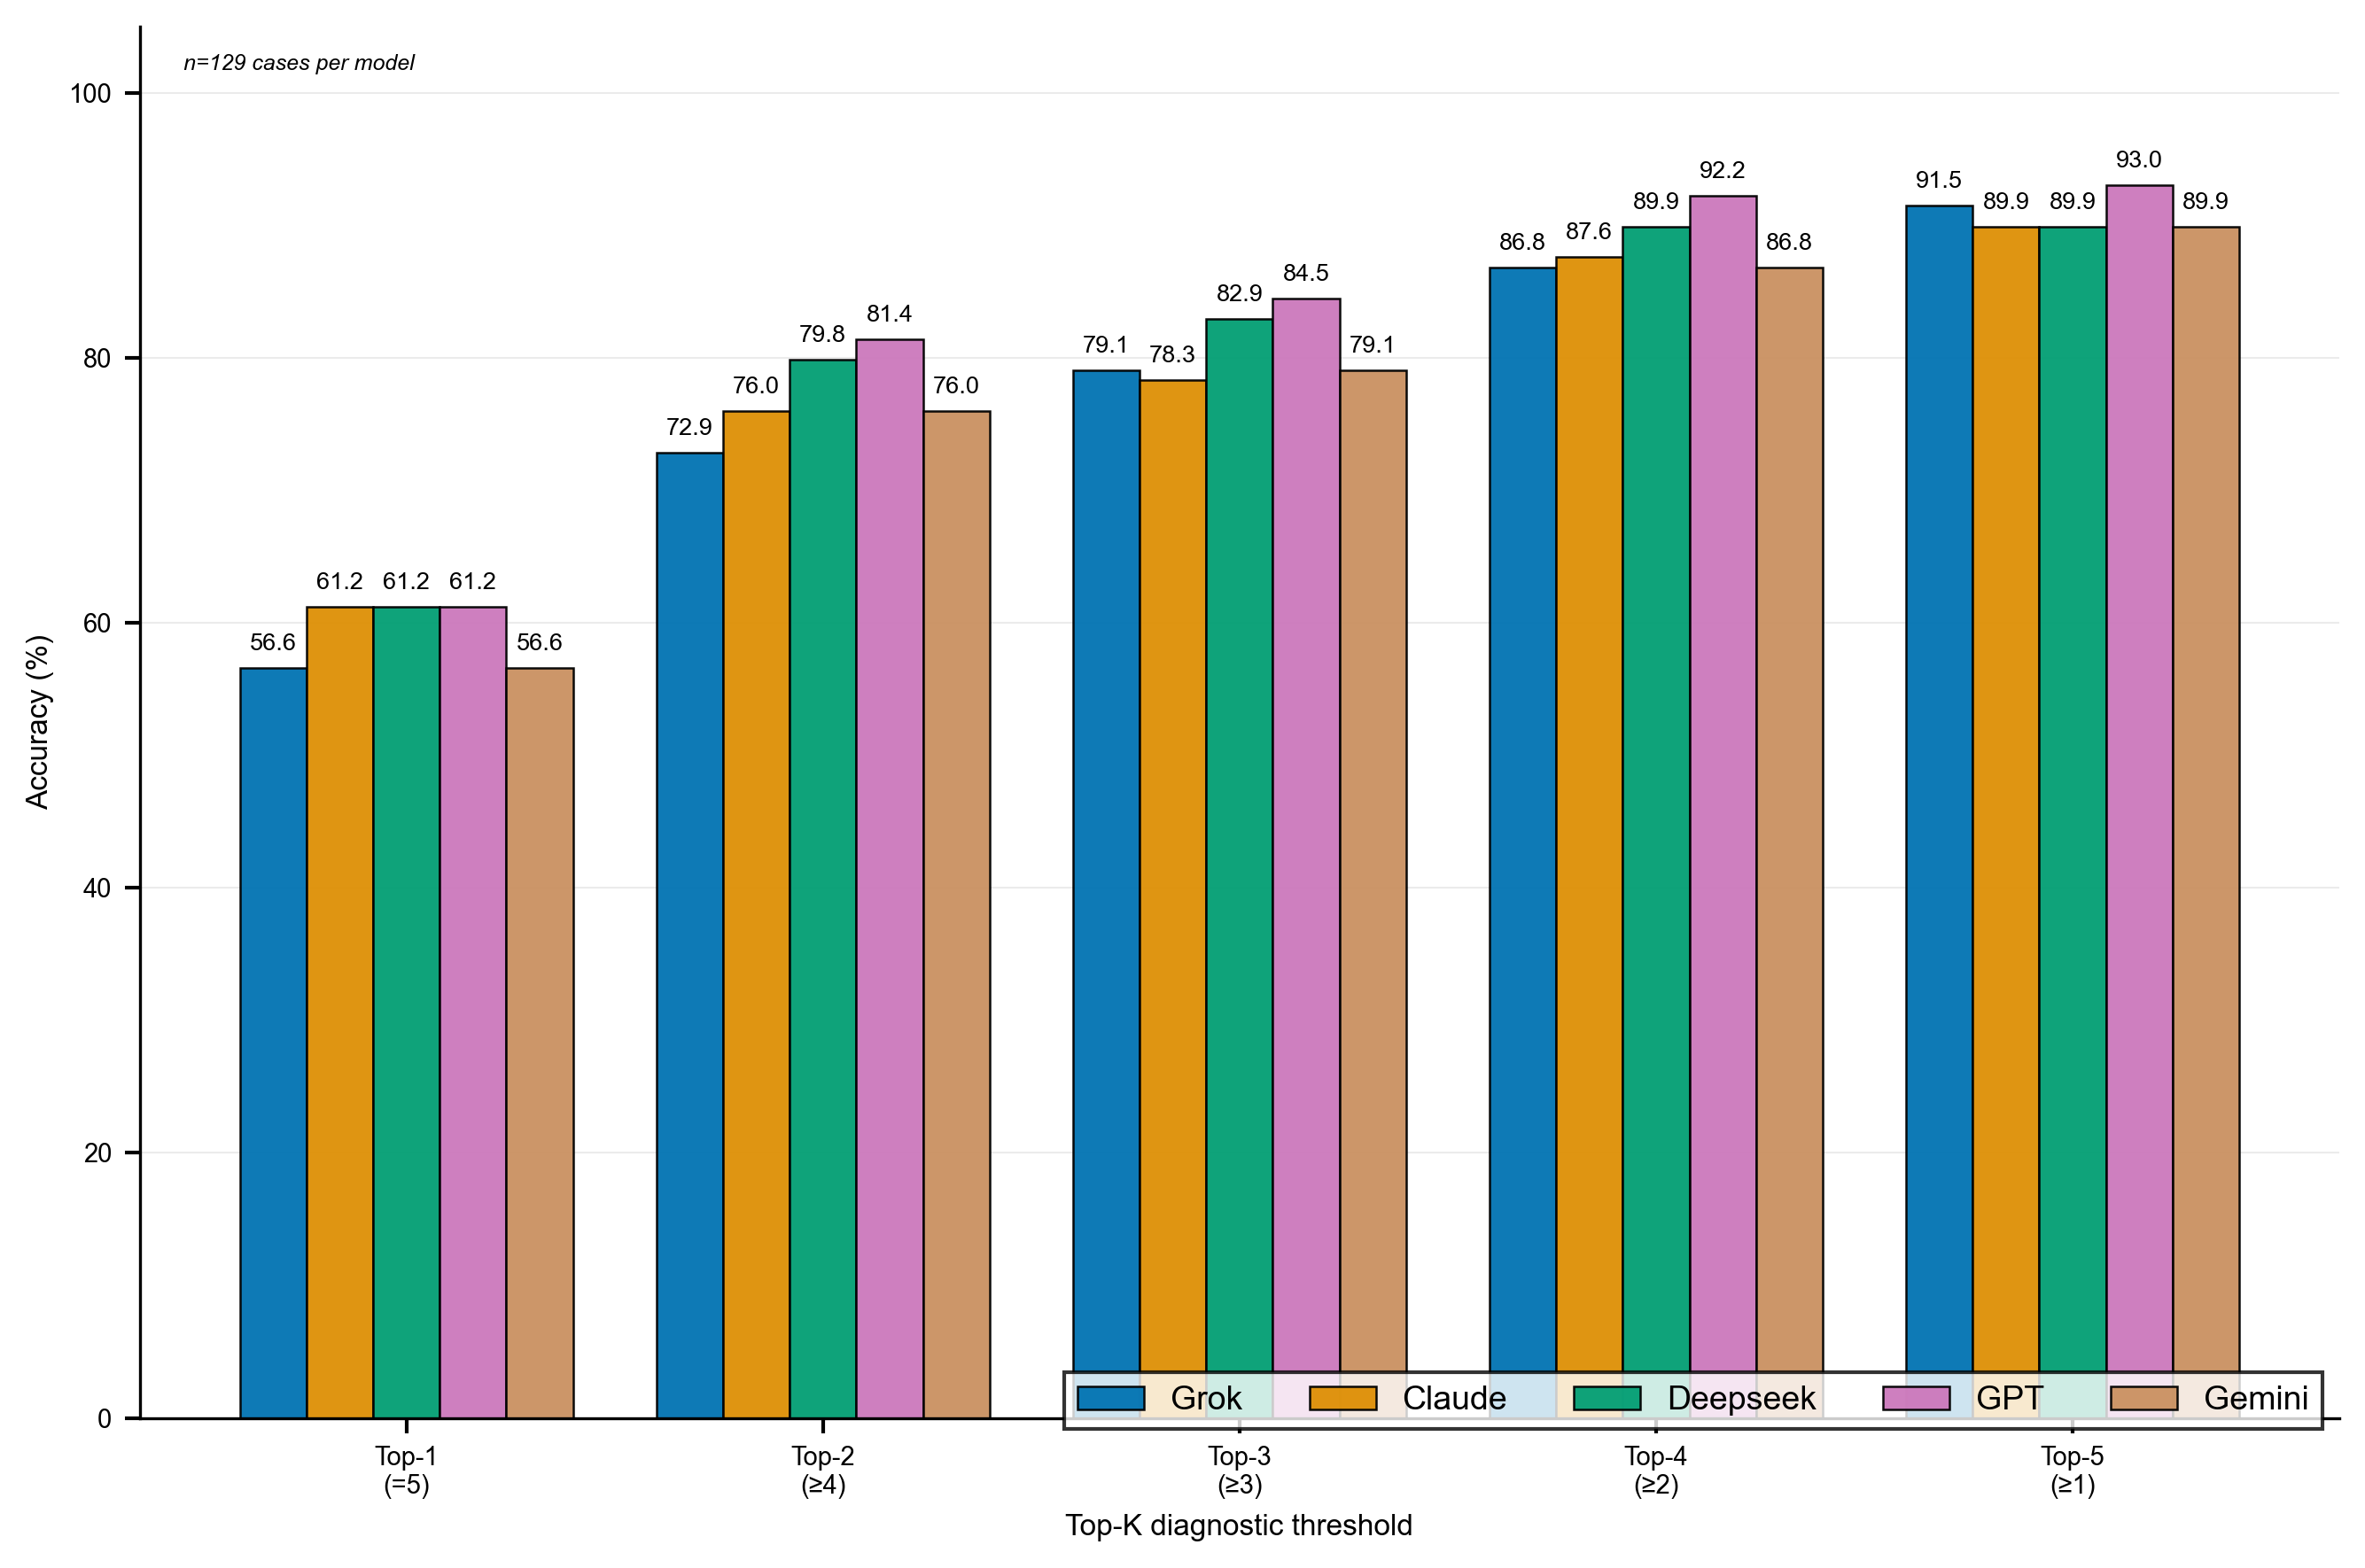

✓ Figure 2 saved (NPJ-ready, borders + labels kept)


In [15]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# 1) NPJ / Nature defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------------
# 2) EXACT color palette (unchanged)
# -------------------------
colors = {
    "Grok": "#0173B2",
    "Claude": "#DE8F05",
    "Deepseek": "#029E73",
    "GPT": "#CC78BC",
    "Gemini": "#CA9161",
}

# -------------------------
# 3) Prepare Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n * 100,
        (scores >= 4).sum() / n * 100,
        (scores >= 3).sum() / n * 100,
        (scores >= 2).sum() / n * 100,
        (scores >= 1).sum() / n * 100,
    ]

# -------------------------
# 4) Plot
# -------------------------
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    bars = ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=colors[model],
        edgecolor="black",      # KEEP borders
        linewidth=0.6,
        alpha=0.95
    )

    # Value labels (on top of bars)
    for j, bar in enumerate(bars):
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 1.0,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=6.5,
            family="Arial"
        )

# -------------------------
# 5) Axes styling
# -------------------------
ax.set_ylabel("Accuracy (%)", fontsize=8, family="Arial")
ax.set_xlabel("Top-K diagnostic threshold", fontsize=8, family="Arial")
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family="Arial")
ax.tick_params(axis="y", labelsize=7)
ax.set_ylim(0, 105)

# Subtle grid (NPJ-style)
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.25)
ax.set_axisbelow(True)

# Spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)

# -------------------------
# 6) Legend (model names at bottom, unchanged structure)
# -------------------------
ax.legend(
    loc="lower right",
    fontsize=7,
    frameon=True,
    edgecolor="black",
    fancybox=False,
    shadow=False,
    ncol=5,
    bbox_to_anchor=(1.0, -0.02),
    prop={"family": "Arial"}
)

# -------------------------
# 7) Sample size annotation
# -------------------------
ax.text(
    0.02, 0.98,
    "n=129 cases per model",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=6,
    family="Arial",
    style="italic"
)

plt.tight_layout()

# -------------------------
# 8) Save (robust, journal-safe)
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

fig.savefig(os.path.join(out_dir, "Figure2_topk_comprehensive.png"),
            dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(os.path.join(out_dir, "Figure2_topk_comprehensive.pdf"),
            bbox_inches="tight", facecolor="white")
fig.savefig(os.path.join(out_dir, "Figure2_topk_comprehensive.tiff"),
            dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("✓ Figure 2 saved (NPJ-ready, borders + labels kept)")


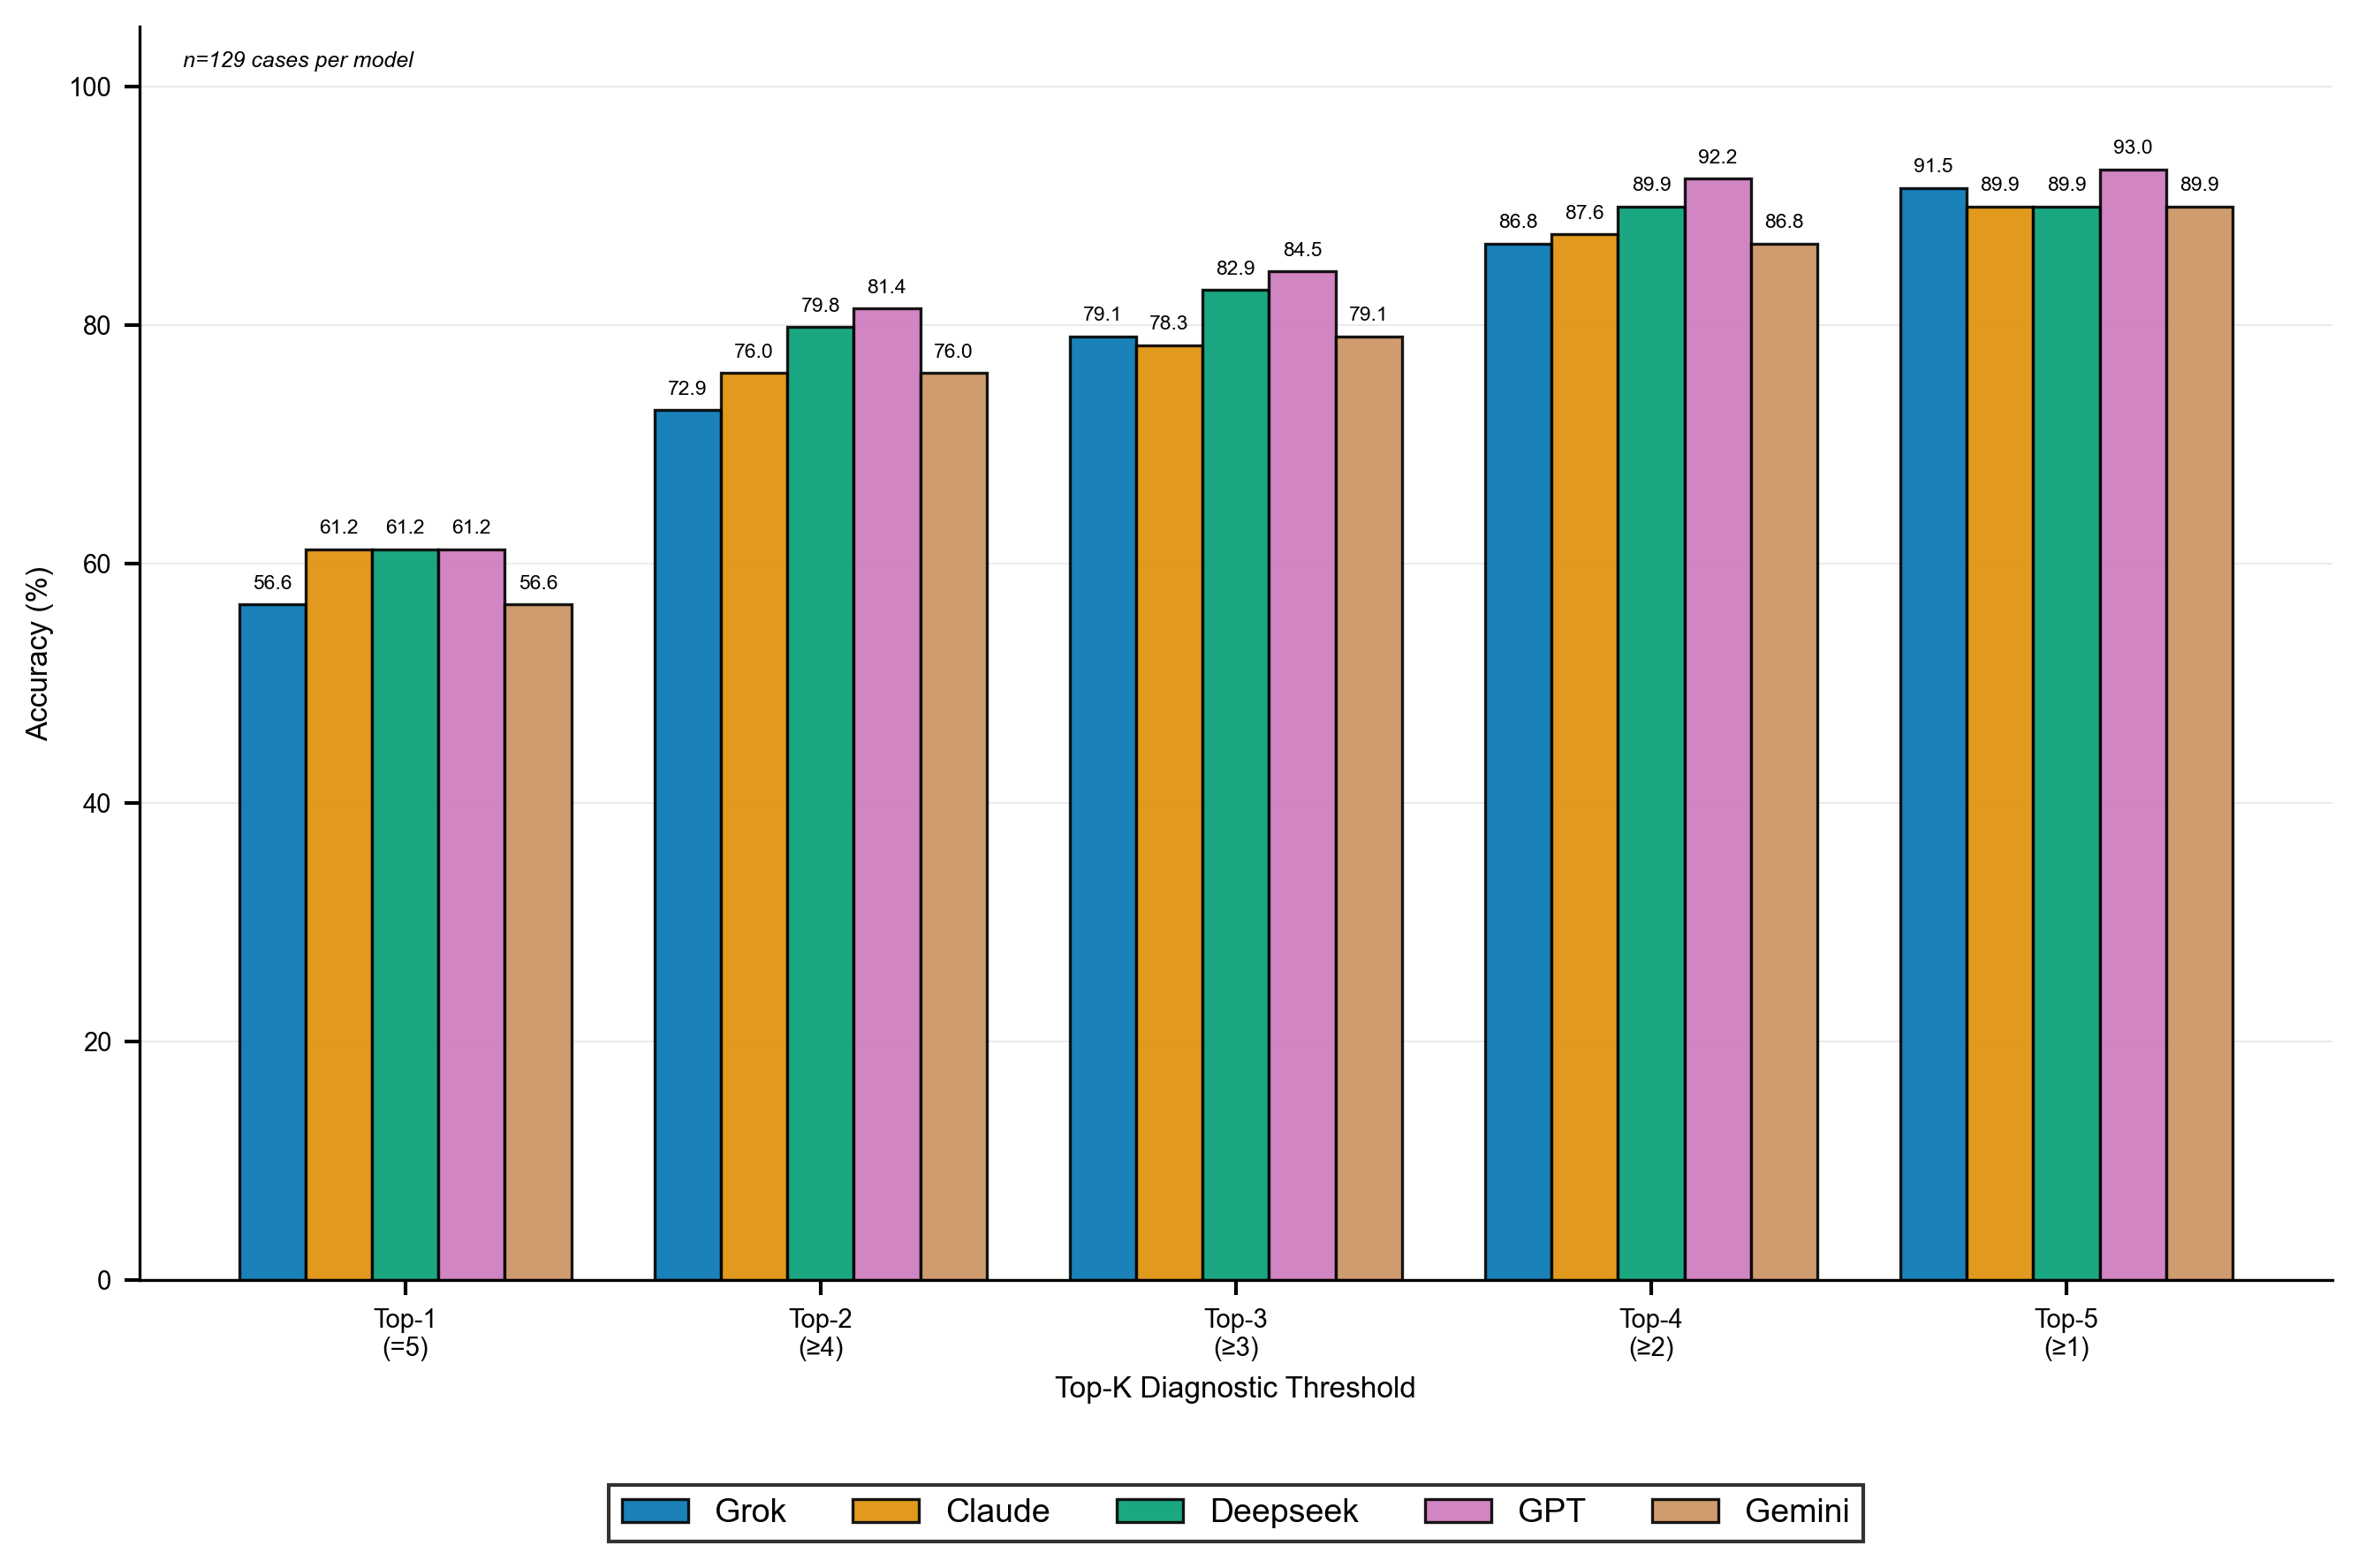

✓ Figure 2 saved (model names/legend unchanged)


In [18]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# NPJ / Nature defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------------
# EXACT same colors as before
# -------------------------
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# -------------------------
# Prepare Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n * 100,
        (scores >= 4).sum() / n * 100,
        (scores >= 3).sum() / n * 100,
        (scores >= 2).sum() / n * 100,
        (scores >= 1).sum() / n * 100,
    ]

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    bars = ax.bar(
        x + offsets[i],
        topk_data[model],
        width,
        color=colors[model],
        label=model,                 # SAME legend labels
        edgecolor="black",           # KEEP border
        linewidth=0.8,
        alpha=0.9
    )

    # Value labels (unchanged behavior)
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 1.0,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=5.5,
            family="Arial"
        )

# -------------------------
# Axes styling (same as before)
# -------------------------
ax.set_ylabel('Accuracy (%)', fontsize=8, family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', labelsize=7)
ax.set_ylim(0, 105)

ax.yaxis.grid(True, linestyle='-', alpha=0.25, linewidth=0.5)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# -------------------------
# LEGEND — EXACTLY like before
# -------------------------
# Legend — model names at the bottom (NPJ style)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),   # <-- bottom centered
    ncol=5,
    fontsize=7,
    frameon=True,
    edgecolor='black',
    fancybox=False,
    shadow=False,
    prop={'family': 'Arial'}
)


# -------------------------
# Annotation
# -------------------------
ax.text(
    0.02, 0.98,
    'n=129 cases per model',
    transform=ax.transAxes,
    fontsize=6,
    va='top',
    ha='left',
    family='Arial',
    style='italic'
)

plt.tight_layout()

# -------------------------
# Save
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.png'),
            dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.pdf'),
            bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.tiff'),
            dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

print("✓ Figure 2 saved (model names/legend unchanged)")


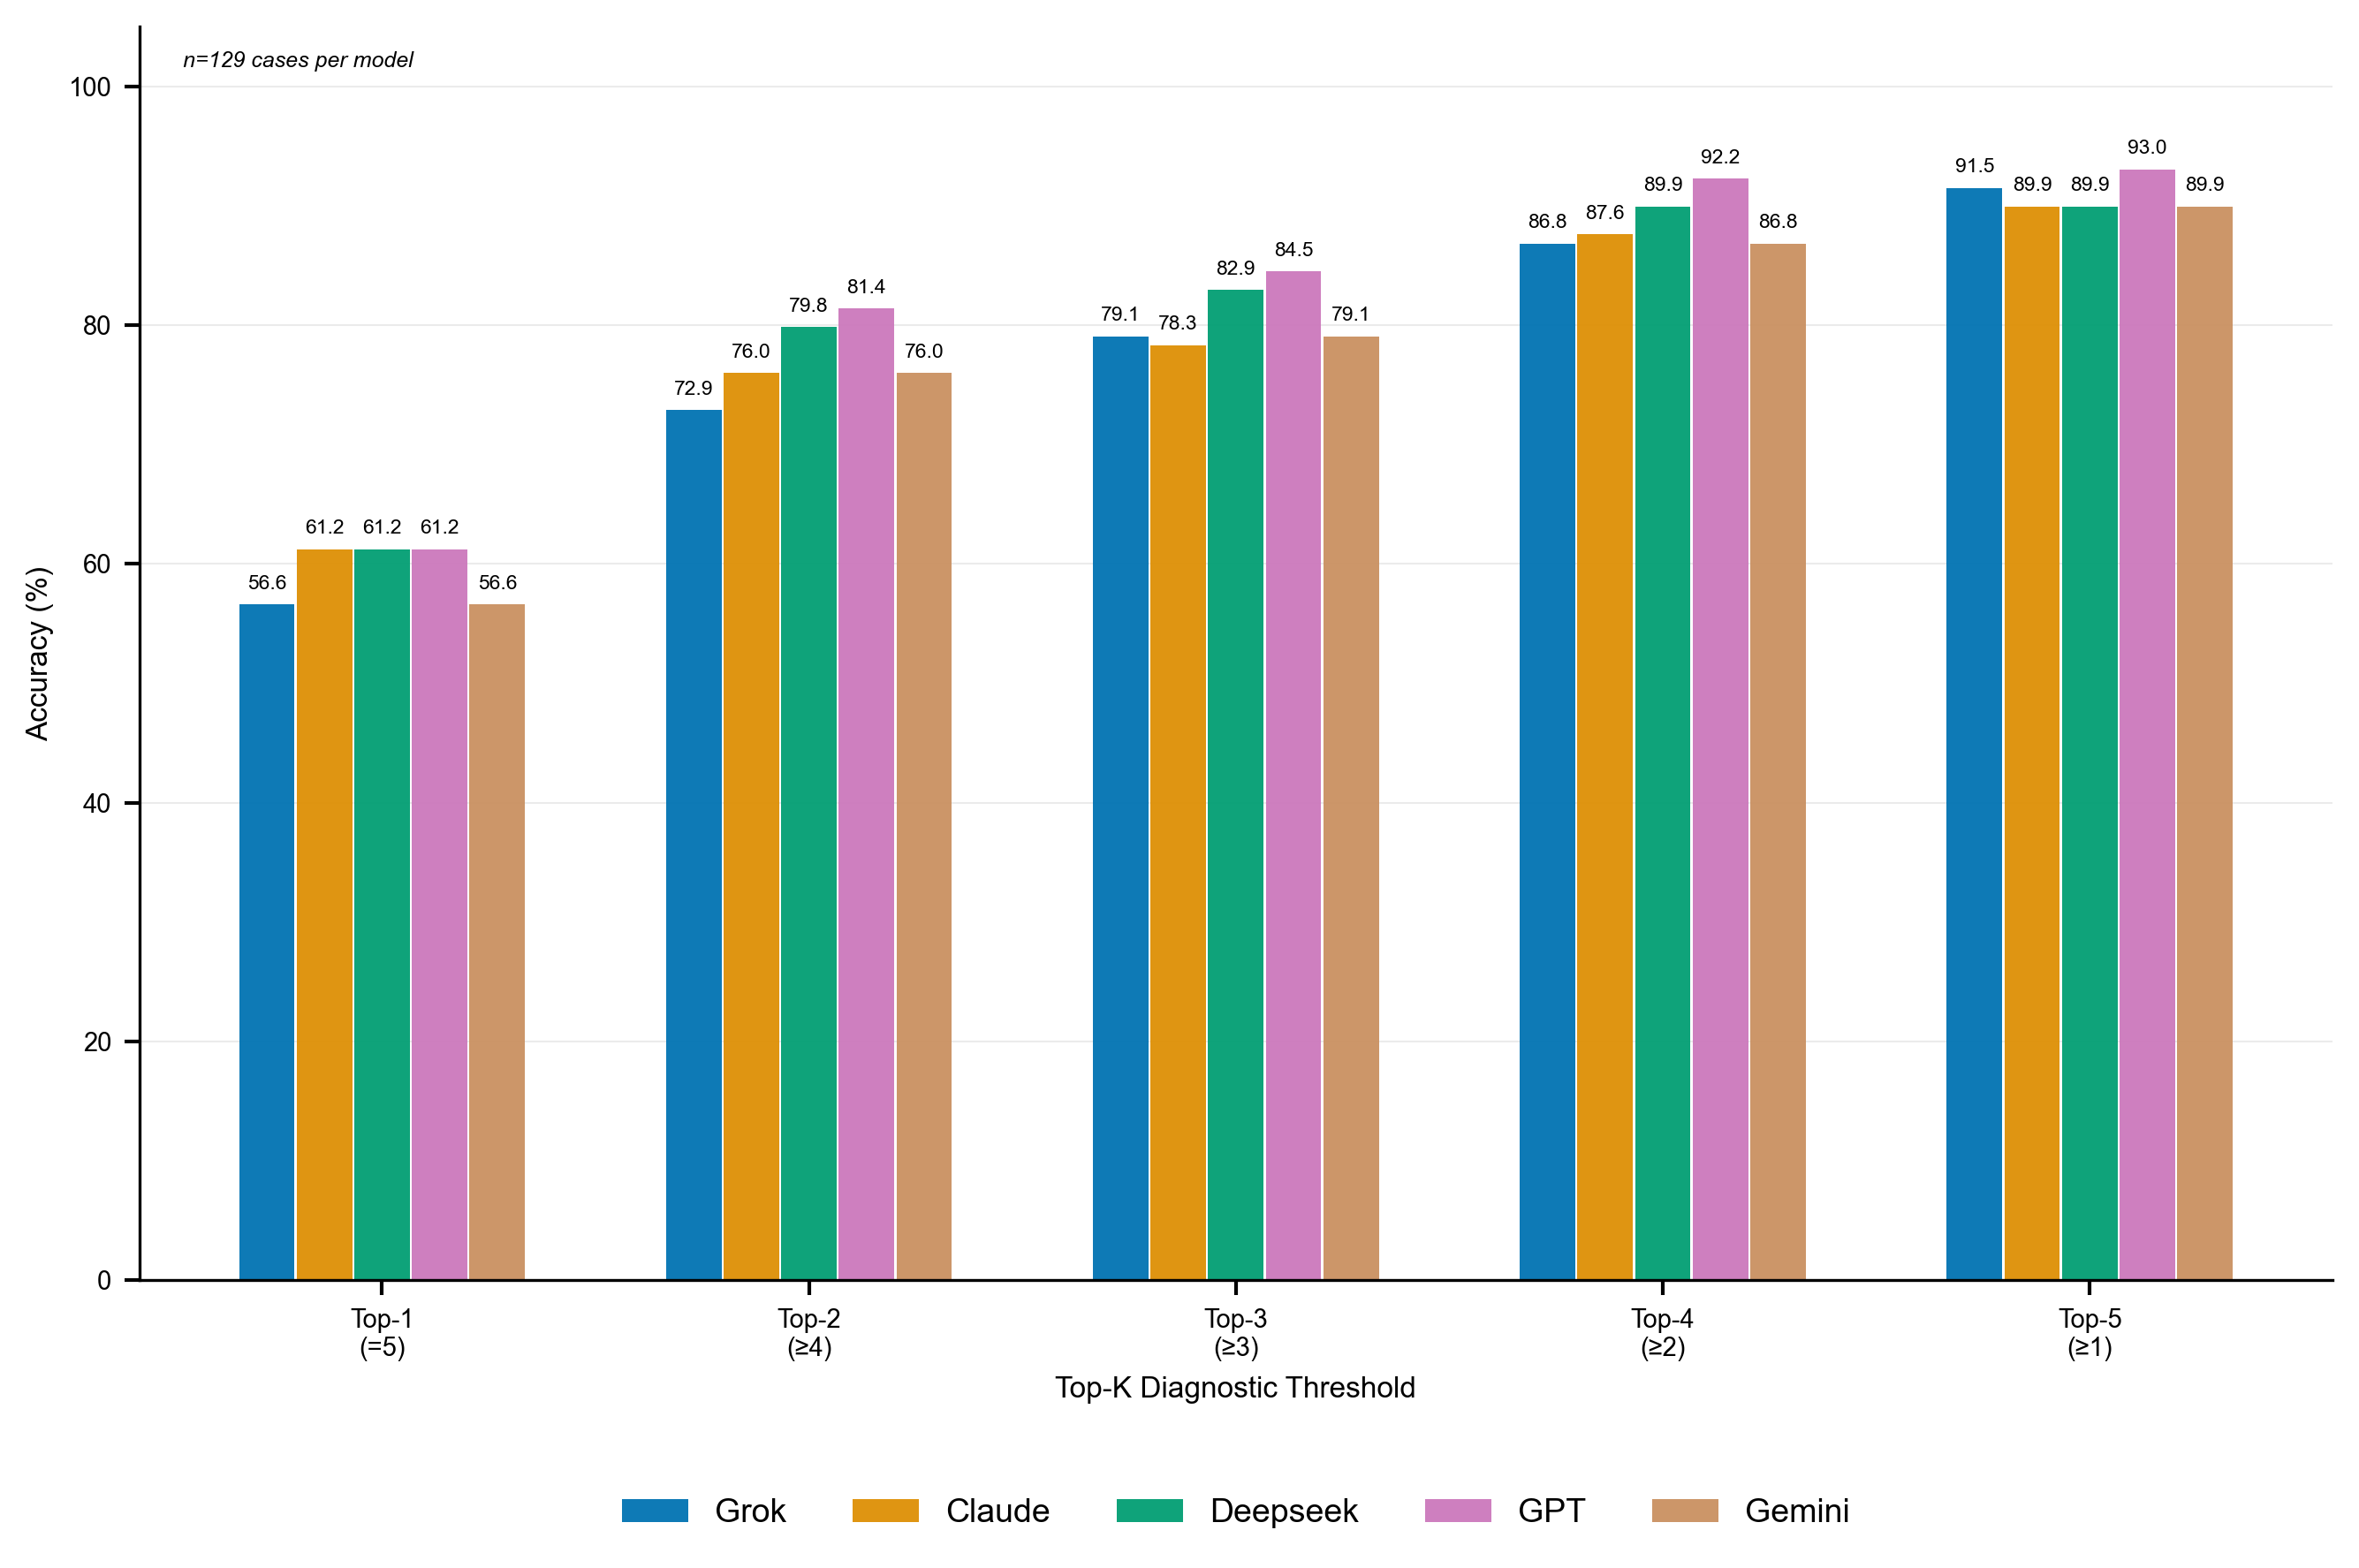

✓ Figure 2 saved (no borders, spaced bars, NPJ-ready)


In [24]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# NPJ / Nature defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.linewidth": 0.8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------------
# EXACT same colors as before
# -------------------------
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# -------------------------
# Prepare Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n * 100,
        (scores >= 4).sum() / n * 100,
        (scores >= 3).sum() / n * 100,
        (scores >= 2).sum() / n * 100,
        (scores >= 1).sum() / n * 100,
    ]

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))

width = 0.13   # narrower bars = more white space (NPJ-friendly)
gap = 0.005
offsets = np.array([-2, -1, 0, 1, 2]) * (width + gap)

for i, model in enumerate(model_names):
    bars = ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        color=colors[model],
        label=model,
        edgecolor='none',     # NO borders
        alpha=0.95
    )

    # Value labels on top
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 1.0,
            f"{h:.1f}",
            ha='center',
            va='bottom',
            fontsize=5.5,
            family='Arial'
        )

# -------------------------
# Axes styling
# -------------------------
ax.set_ylabel('Accuracy (%)', fontsize=8, family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', labelsize=7)
ax.set_ylim(0, 105)

# Subtle grid (NPJ)
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.25)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# -------------------------
# Legend — model names at the bottom (unchanged labels)
# -------------------------
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    fontsize=7,
    frameon=False,
    prop={'family': 'Arial'}
)

# -------------------------
# Sample size annotation
# -------------------------
ax.text(
    0.02, 0.98,
    'n=129 cases per model',
    transform=ax.transAxes,
    fontsize=6,
    va='top',
    ha='left',
    family='Arial',
    style='italic'
)

plt.tight_layout()

# -------------------------
# Save (journal-safe)
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.png'),
            dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.pdf'),
            bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.tiff'),
            dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

print("✓ Figure 2 saved (no borders, spaced bars, NPJ-ready)")
